`Total Sequences downloaded :        124090`

`Total Sequences from India :        124089  (1 from Bangladesh)`

`Total seq from India wo dups:       123998  (91 removed for duplicacy)`

`Total seq considered for meta based study:  123998`
<hr>

`Total seq aligned successfully:     123992    (6 failed alignment process)`

`Total Sequences found good :        93095     (30897 found to be bad seq)`


`'State Unassigned' row in states.tsv caused column for 'Other' in regionwise study`

`Data with same id (or strain name) has been removed keeping last row only in each duplicacy.`

### File Names: <br> ###
1: Raw sequences in seperate files                      <br>
> Sequence: .\data\gisaid_rawSeq_new_sep\2020\sequences\    <br>



> Metadata: .\data\gisaid_rawSeq_new_sep\2020\metadata\     <br>

2: Raw sequences combined                               <br>
> Sequence: .\data\gisaidRawCombined\2020\sequences\    <br>
> Metadata: .\data\gisaidRawCombined\2020\metadata\     <br>

In [ ]:
# writer = pd.ExcelWriter(f'outputs/{year}/2_2_casesvsseq_rw.xlsx', engine='xlsxwriter')
# for i in range(len(zones)):
#     pd.DataFrame({'Month' : months, 'Monthly Cases': zonalCasesMonthWiseGraph[i], 'Monthly Seq': zonalSeqMonthWiseGraph[i]}).to_excel(writer, sheet_name=zones[i], index=False)
# writer.save()

In [1]:
year = '2021'

In [2]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
lim = 5

In [3]:
# folder paths
rawSeqSepPath = f'./data/gisaid_rawSeq_new_sep/{year}/sequences/'
rawMetSepPath = f'./data/gisaid_rawSeq_new_sep/{year}/metadata/'
rawSeqCombPath = f'./data/gisaidRawCombined/{year}/'
nextCladeResourcePath = r'./data/nextCladeRequirements/sars-cov-2/'
mutationResultPath = f'./data/MutationResult/{year}/'

nextClade_exe = r'.\tools\NextClade\nextclade.exe'
nextAlign_exe = r'.\tools\NextAlign\nextalign.exe'
mafft_exe = r'.\tools\mafft\mafft.bat'

In [4]:
# !{nextClade_exe} -h

##### Creating zones

In [ ]:
# ???? Sikkim Eastern or North Eastern ????

In [4]:
zones = ['India', 'Northern Zone', 'Central Zone', 'Eastern Zone', 'Western Zone', 'Southern Zone', 'North Eastern Zone', 'Others']
zonesRegex = [
    'India',                                                                                # count = 1
    'Haryana|Himachal Pradesh|Jammu and Kashmir|Punjab|Rajasthan|Delhi|Chandigarh|Ladakh',  # count = 8
    'Chhattisgarh|Uttarakhand|Uttar Pradesh|Madhya Pradesh',                                # count = 4
    'Bihar|Jharkhand|Odisha|West Bengal',                                                   # count = 4
    'Goa|Gujarat|Maharashtra|Dadra',                                                        # count = 4
    'Andhra Pradesh|Karnataka|Kerala|Tamil Nadu|Puducherry|Telangana|Andaman|Lakshadweep',  # count = 8
    'Assam|Arunachal Pradesh|Manipur|Tripura|Mizoram|Meghalaya|Nagaland|Sikkim',            # count = 8
    'Unassigned'                                                                            # count = 1
    ]

<br><br><br><br><br>

#### Importing Libraries

In [5]:
# important libraries
import os
import Bio.SeqIO as SeqIO
import Bio.Seq as Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import nltk
%matplotlib inline

<br><br><br><br><br>

### Sequences Combination into One File/List <br>

> The sequence files are combined into one in order so that the final sequence file contains all sequences.

In [6]:
def remDups(seqs):
    metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')

    tbr = []
    tbr.extend(list(metas[metas['division'] == 'Bangladesh'].strain.values))

    tbd = []
    for id, bval in dict(metas['strain'].value_counts() >= 2).items():
        if bval:
            tbd.append(id)

    seqs = seqs[::-1]
    resSeq = []
    for seq in seqs:
        if seq.id in tbr:
            continue
        elif seq.id in tbd:
            tbr.append(seq.id)
        resSeq.append(seq)
    resSeq = resSeq[::-1]
    return resSeq

In [10]:
rawfilenum = len(os.listdir(rawSeqSepPath))
allseq = []
for i in range(1, rawfilenum+1):
    inpfile = rawSeqSepPath + str(i) + '.fasta'
    seq = list(SeqIO.parse(inpfile, 'fasta'))
    print(i, len(seq))
    allseq += seq
del i
del inpfile
del seq
del rawfilenum
outfile = rawSeqCombPath + 'allseq.fasta'
print('all w dups', len(allseq))
allseq = remDups(allseq)
print('all wo dups', len(allseq))
SeqIO.write(allseq, outfile, 'fasta')
del outfile
del allseq

1 4939
2 4672
3 4841
4 4760
5 4704
6 4458
7 4787
8 4842
9 4957
10 4722
11 4773
12 4999
13 4961
14 4821
15 4807
16 4627
17 4924
18 4875
19 4739
20 4885
21 4838
22 4662
23 4817
24 4856
25 4481
26 4343
all w dups 124090
all wo dups 123998


### Metadata Combination into One File/List <br>

> The sequence files are combined into one in order so that the final sequence file contains all sequences.

In [8]:
def remMeta(metas):
    metas.drop_duplicates('strain', keep='last', inplace=True)
    tbr = []
    tbr.extend(list(metas[metas['division'] == 'Bangladesh'].strain.values))
    metas.drop((metas[metas['strain'] == tbr[0]]).index, inplace=True)

def correctDiv(metas):
    div_t_dict = {
        'Pondicherry' : 'Puducherry',
        'Jammu & Kashmir' : 'Jammu and Kashmir',
        'Chhatisgarh' : 'Chhattisgarh',
        'Tamilnadu' : 'Tamil Nadu',
        'Maharasthra' : 'Maharashtra',
        'Jammu and Kashmīr' : 'Jammu and Kashmir',
        'Jammu' : 'Jammu and Kashmir',
        'Maharshtra' : 'Maharashtra',
        'Harayana' : 'Haryana',
        'Jarkhand' : 'Jharkhand',
        'Andhra pradesh' : 'Andhra Pradesh',
        'Gujrat' : 'Gujarat',
        'Gujart' : 'Gujarat',
        'Jaipur' : 'Rajasthan',
        'New Delhi' : 'Delhi'
    }
    metas['division'].replace(div_t_dict, inplace=True)

In [9]:
rawfilenum = len(os.listdir(rawMetSepPath))
data = pd.DataFrame()
for i in range(1, rawfilenum+1):
    inpfile = rawMetSepPath + str(i) + '.tsv'
    data1 = pd.read_csv(inpfile, sep='\t')
    data = pd.concat([data, data1], axis=0)
outfile = rawSeqCombPath + 'all.tsv'
epi_loc = f'./outputs/{year}/epi_isl.csv'

if year == '2020':
    nstrain = data[data['division'] == 'Nairobi']['strain'].values[0]
    data = data.loc[data['division'] != 'Nairobi']
print('meta len: ', len(data))
pd.DataFrame.to_csv(data, outfile, sep='\t')
metas = pd.read_csv(outfile, sep='\t')
remMeta(metas)
correctDiv(metas)
print('meta len: ', len(metas))
pd.DataFrame.to_csv(metas, outfile, sep='\t')
pd.DataFrame(list(data['gisaid_epi_isl'])).to_csv(epi_loc, sep=',', index=False)
del i
del data1
del data
del outfile
del inpfile
del rawfilenum

meta len:  124090
meta len:  123998


<br><br><br><br><br>

#### Setting up Nextclade exe data directory by downloading latest requirements

In [10]:
# command to download latest data on sars-cov-2 for NextClade to work on alignment and mutation.
!{nextClade_exe} dataset get --name sars-cov-2 --output-dir {nextCladeResourcePath}

In [11]:
os.remove(r'./data/nextCladeRequirements/sars-cov-2/sequences.fasta')

<br><br><br><br><br>

#### Running NextClade for alignment and mutation calculation

In [11]:
!{nextClade_exe} run --input-dataset {nextCladeResourcePath} --output-all={mutationResultPath} {rawSeqCombPath}allseq.fasta

2023-04-16 09:12:23.824 [W] nextclade_ordered_writer.rs:166: In sequence #9689 'hCoV-19/India/AP-CCMB-BK677/2021': Unable to align: seed matches suggest large indels or are ambiguous due to duplications.. Note that this sequence will not be included in the results.
2023-04-16 09:12:23.940 [W] nextclade_ordered_writer.rs:166: In sequence #9722 'hCoV-19/India/AP-CCMB-BK659/2021': Unable to align: seed matches suggest large indels or are ambiguous due to duplications.. Note that this sequence will not be included in the results.
2023-04-16 09:13:32.205 [W] nextclade_ordered_writer.rs:166: In sequence #24966 'hCoV-19/India/UP-CCMB-CIA1752/2021': Unable to align: seed matches suggest large indels or are ambiguous due to duplications.. Note that this sequence will not be included in the results.
2023-04-16 09:19:42.536 [W] nextclade_ordered_writer.rs:166: In sequence #49763 'hCoV-19/India/MP-NCDC-4309194/2021': Unable to align: seed matches suggest large indels or are ambiguous due to duplic

<br><br><br><br><br>

### Mutation extraction, representation and function definations

In [7]:
# 1-D List plotter function
def plot1D(data, index, title, ylabel, xlabel, legend = 'Cases', bool_legend=True):
    ax = pd.DataFrame(data, index=index, columns=[legend]).plot(kind='bar', figsize=(20, 10), title=title, legend=bool_legend)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()*1.005, p.get_height()*1.015))

In [8]:
def plot2Ddict(data, index, title, ylabel, xlabel, bool_legend=True):
    ax = pd.DataFrame(data, index=index).plot(kind='bar', figsize=(25, 10), legend=bool_legend)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()*1.005, p.get_height()*1.015))

In [6]:
def readfile(filename, sep=','):
    handle = open(filename)
    df = pd.read_csv(handle, sep=sep)
    df.drop(df[df['clade'].isnull()].index, inplace=True)
    return df

In [10]:
def mergeNucMutation(df, col='substitutions', sep=','):
    tres = []
    for it in df[col]:
        tres += list(str(it).split(sep=sep))
    freq = nltk.FreqDist(tres)
    freq = dict(sorted(freq.items(), key=lambda item:item[1], reverse=True))
    return freq

In [11]:
mut_master_df = readfile(mutationResultPath + 'nextclade.csv', sep=';')

C:\Users\sachi\AppData\Local\Temp\ipykernel_16248\3587794418.py:3: DtypeWarning: Columns (67,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(handle, sep=sep)


In [12]:
mut_master_df['qc.overallStatus'].value_counts()

good        68749
bad         30897
mediocre    24346
Name: qc.overallStatus, dtype: int64

In [13]:
mut_master_df = readfile(mutationResultPath + 'nextclade.csv', sep=';')
# delete all bad sequences.
mut_master_df.drop(mut_master_df[mut_master_df['qc.overallStatus'] == 'bad'].index, inplace=True)

C:\Users\sachi\AppData\Local\Temp\ipykernel_16248\3587794418.py:3: DtypeWarning: Columns (67,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(handle, sep=sep)


In [14]:
len(mut_master_df)

93095

In [7]:
metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')
len(metas)

123998

Setting up meta data

In [15]:
metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')
seqNames =  list(mut_master_df['seqName'])
drop = metas[~metas['strain'].isin(seqNames)]
metas.drop(drop.index, inplace=True)
metas = metas[['strain', 'date', 'region', 'country', 'division', ]].copy()

In [16]:
len(metas)

93095

<br>

In [16]:
nucMut = mergeNucMutation(mut_master_df, col='substitutions', sep=',')

In [17]:
def plotNucMut(nucMut : dict, title : str, n : int = 20) -> None :
  # num = 20
  x = list(nucMut.keys())[:n]
  y = list(nucMut.values())[:n]

  fig, ax = plt.subplots(figsize=(22,4))
  plt.bar(x, y)
  for index in range(len(x)):
    ax.text(x[index], y[index], y[index], size=12)
  # plt.xticks(x, size=12)
  # plt.yticks([i for i in range(20)], size=12)
  # plt.grid()
  plt.title(title)
  plt.show()

In [14]:
mut_master_df['aaSubstitutions'][0]

'N:T393I,ORF1b:P314L,ORF9b:G38D,S:Q271R,S:D614G'

In [18]:
def mergeAaMutation(df, col='aaSubstitutions', sep=','):
    tres = {}
    for el in df[col]:
        muts = list(str(el).split(sep))
        for mut in muts:
            # print(mut)
            if mut == 'nan':
                continue
            aa, ch = mut.split(sep=':')
            if aa in tres.keys():
                tres[aa].append(ch)
            else:
                tres[aa] = [ch]
    for key in tres.keys():
        freq = nltk.FreqDist(tres[key])
        tres[key] = dict(sorted(freq.items(), key=lambda item:item[1], reverse=True))
    tres = dict(sorted(tres.items(), key = lambda item : sum(item[1].values()), reverse=True))
    return tres
            

In [42]:
aaMut = mergeAaMutation(mut_master_df)

In [17]:
total = 0
for key in aaMut.keys():
    print(key, sum(aaMut[key].values()))
    for mut in aaMut[key].keys():
        if '-' in mut:
            print(mut, aaMut[key][mut])

ORF1a 22809
ORF1b 18030
S 16670
N 15895
ORF3a 9470
ORF8 3158
ORF9b 1018
ORF7a 657
ORF7b 406
M 398
E 309
ORF6 218


In [45]:
def plotAAMut(aaMut : dict, title : str, num : int = 20, grid : bool = True, figsize : tuple = (20, 100)) -> None :
  # num = 20
  n = len(aaMut.keys())
  i = 1
  f = plt.figure(figsize=(22, 52))
  for key in aaMut.keys():
    x = list(aaMut[key].keys())[:num]
    y = list(aaMut[key].values())[:num]
    ax = f.add_subplot(n, 1, i)
    ax.bar(x, y)
    for index in range(len(x)):
      ax.text(x[index], 1.05*y[index], y[index], size=12)
    # plt.xticks(x, size=12)
    # plt.yticks([i for i in range(20)], size=12)
    if grid:
      ax.grid()
    ax.set_title(key)
    i += 1
  f.suptitle(title)
  f.tight_layout(pad=5.0)
  plt.show()

In [19]:
def func_monthly_mut_stat(metas, mut_df):
    res_stat = {}
    for month in months:
        d_temp = metas['date'].str.match(f'^{year}-{month}')
        ids = [strain for idx, strain in enumerate(metas.strain) if d_temp[idx]]
        t_mut_df = mut_df.loc[mut_df['seqName'].isin(ids)]
        tpango = dict(t_mut_df.Nextclade_pango.value_counts())
        t_nucMut = mergeNucMutation(t_mut_df, col='substitutions', sep=',')
        t_aaMut = mergeAaMutation(t_mut_df)
        res_stat[month] = [len(t_mut_df), t_nucMut, t_aaMut, tpango]
    return res_stat

In [20]:
def func_region_mut_stat(metas, mut_df):
    res_stat = {}
    for i in range(len(zones)):
        d_temp = metas['division'].str.match(f'{zonesRegex[i]}')
        ids = [strain for idx, strain in enumerate(metas.strain) if d_temp[idx]]
        t_mut_df = mut_df.loc[mut_df['seqName'].isin(ids)]
        tpango = dict(t_mut_df.Nextclade_pango.value_counts())
        t_nucMut = mergeNucMutation(t_mut_df, col='substitutions', sep=',')
        t_aaMut = mergeAaMutation(t_mut_df)
        res_stat[zones[i]] = [len(t_mut_df), t_nucMut, t_aaMut, tpango]
    return res_stat

<br><br><br><br><br>

### Overall (yearly) mutations and records

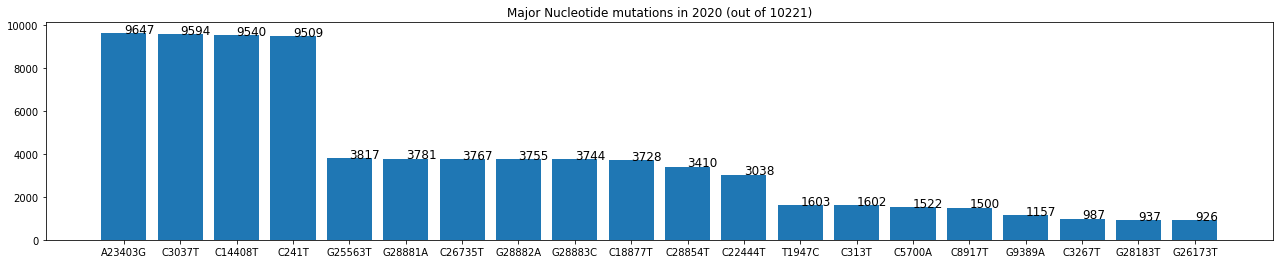

In [18]:
plotNucMut(nucMut, f'Major Nucleotide mutations in {year} (out of {len(mut_master_df)})')

# \### 3.1

In [109]:
# DOC WRITE: nucleotide mutation
n = 10
t = pd.DataFrame((list(nucMut.keys())[:n], list(nucMut.values())[:n]), index=['Mutation', 'Count'], columns=range(1, n+1)).T
t.to_csv(f'outputs/{year}/3_1_nuc_mut_t10.csv')
del t

# \### 5.1

In [20]:
# DOC WRITE: Pango lineage t10
t = dict(mut_master_df.Nextclade_pango.value_counts())
n = 10
t = pd.DataFrame((list(t.keys())[:n], list(t.values())[:n]), index=['Pango', 'Count'], columns=range(1, n+1)).T
t.to_csv(f'outputs/{year}/5_1_pango_t10.csv')
del t

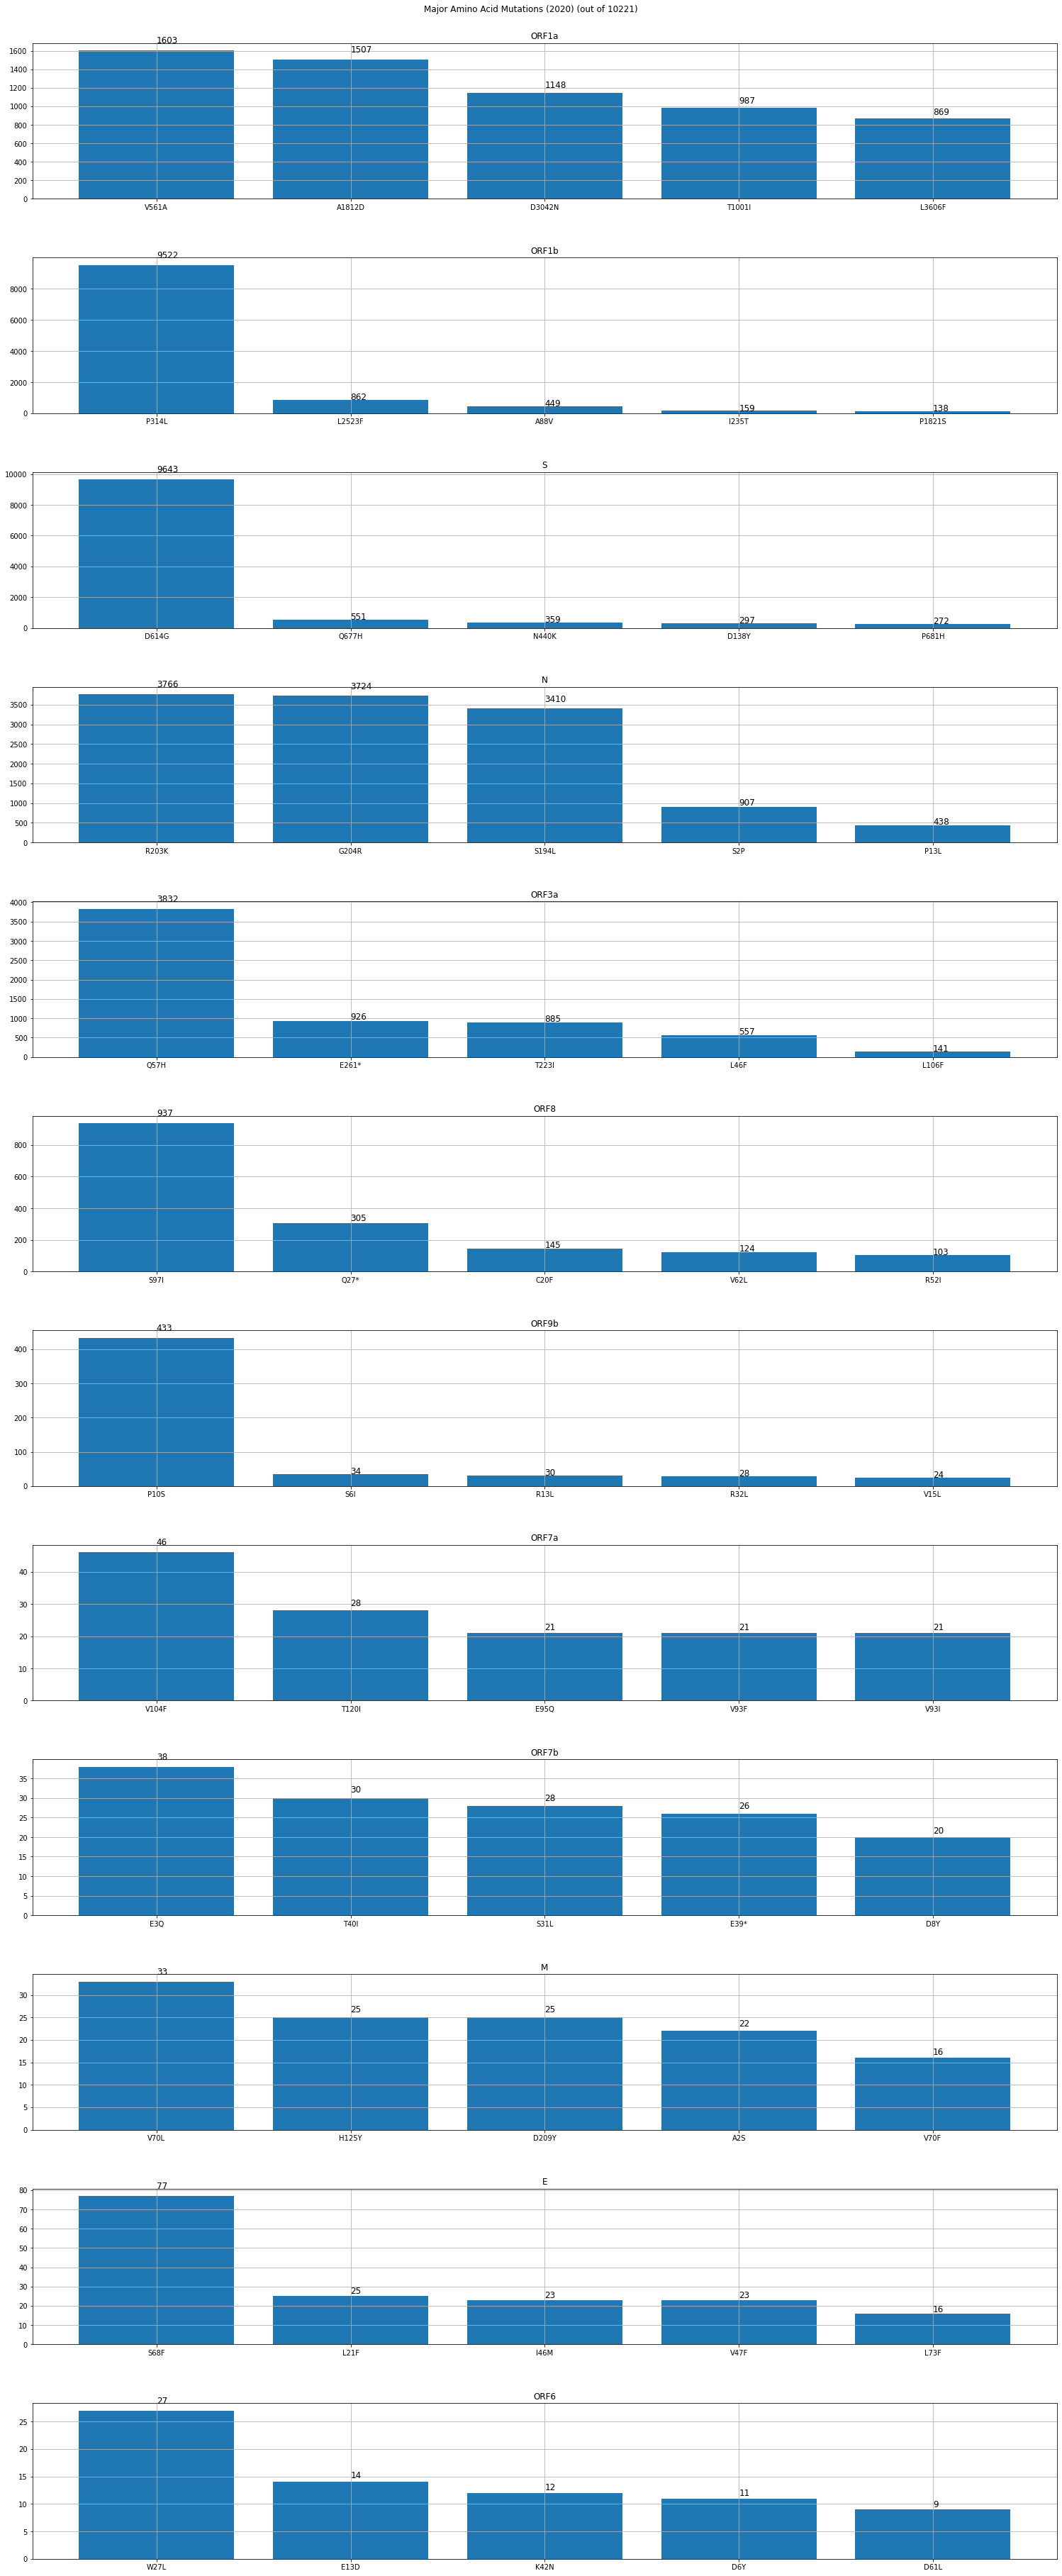

In [19]:
plotAAMut(aaMut, f'Major Amino Acid Mutations ({year}) (out of {len(mut_master_df)})', num=5)

In [50]:
# aaMut

# \### 4.1

In [121]:
n = 10
writer = pd.ExcelWriter(f'outputs/{year}/4_1_aa_mut_t{n}.xlsx', engine='xlsxwriter')
for aaR in aaMut.keys():
    tdf = pd.DataFrame((list(aaMut[aaR].keys())[:n], list(aaMut[aaR].values())[:n]), index=['Mutation', 'Count'], columns=range(1, n+1)).T
    tdf.to_excel(writer, sheet_name=aaR, index=True)
writer.save()
writer.close()

c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


#### Pangolineage mutations

In [20]:
n = 10
tpango = dict(mut_master_df.Nextclade_pango.value_counts())
labels = list(tpango.keys())[:n]
vals = list(tpango.values())[:n]

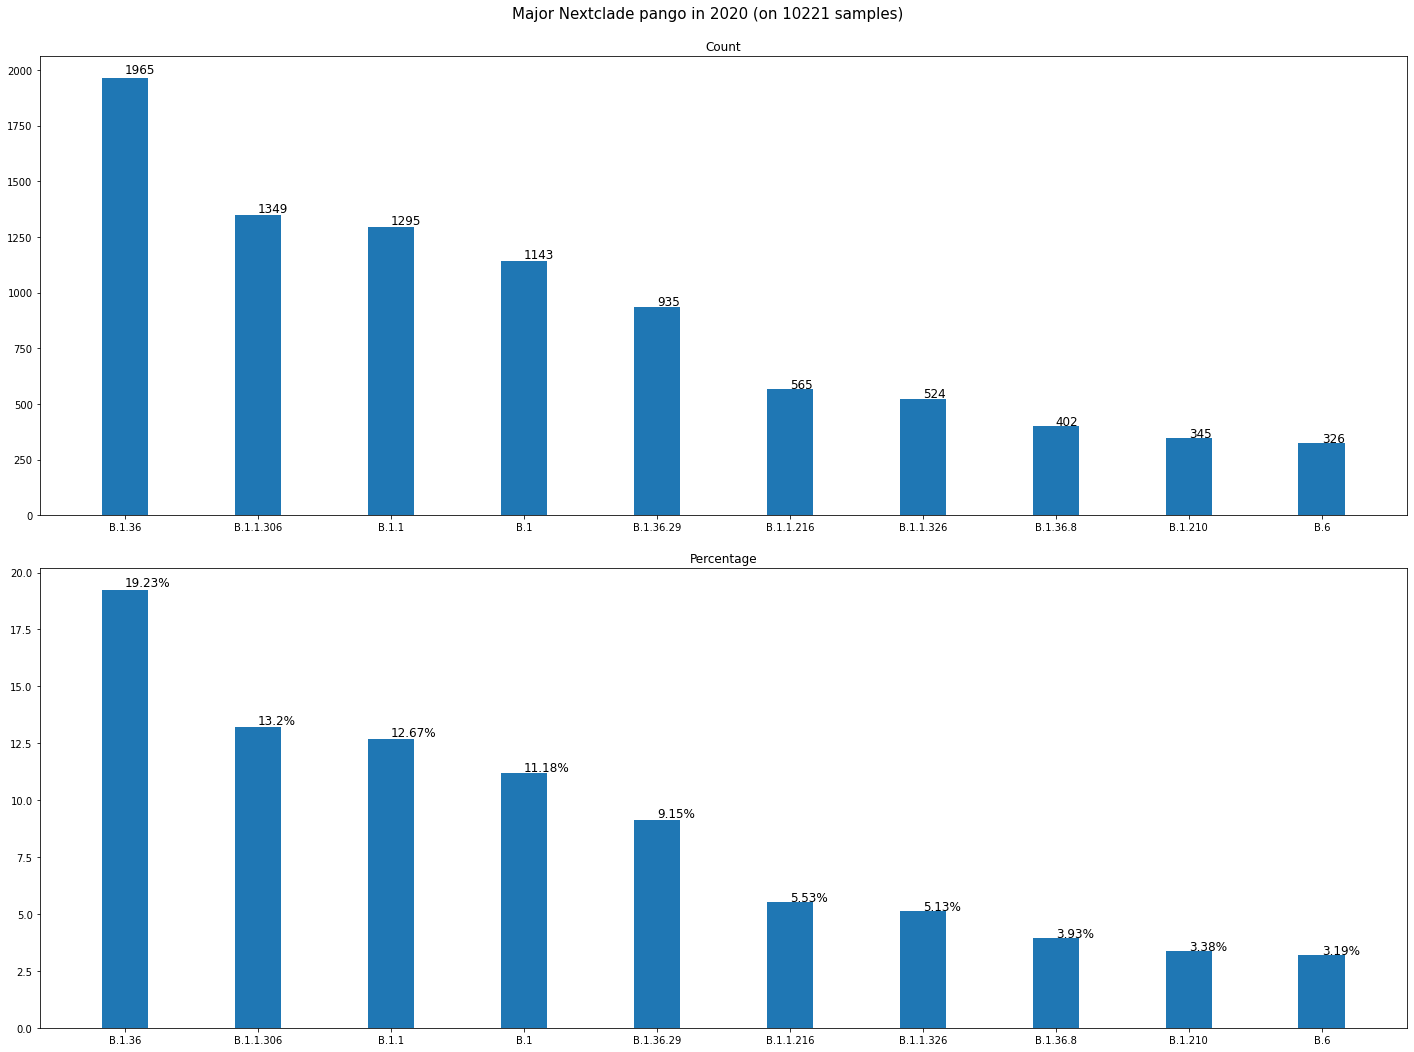

In [21]:
f, (ax, bx) = plt.subplots(nrows=2, figsize=(20, 15))

ax.bar(labels, vals, width=0.35)
ax.set_title("Count")
for i in range(n):
    ax.text(labels[i], 1.01*vals[i], vals[i], size=12)

bx.bar(labels, [val/sum(list(tpango.values()))*100 for val in vals], width=0.35)
bx.set_title("Percentage")
for i in range(n):
    bx.text(labels[i], 1.01 * vals[i]/sum(list(tpango.values()))*100, str(round(vals[i]/sum(list(tpango.values()))*100, 2)) + '%', size=12)

f.suptitle(f"Major Nextclade pango in {year} (on {sum(list(tpango.values()))} samples)", size=15)
f.tight_layout(pad=2)
plt.show()

<br><br><br><br><br><br>

### Monthly stats


In [23]:
# metas 
metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')

In [22]:
month_mutation_stat = func_monthly_mut_stat(metas, mut_master_df)

<br>

##### Nucleotidic mutations

In [114]:
lim = 10
month_nuc_mut_major = [[list(val[1].keys())[:lim],list(val[1].values())[:lim]] for (month, val) in month_mutation_stat.items()]

# \### 3.2

In [115]:
# DOC_SAVE      Nuc mut monthly overall
n = 10
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for month in months:
    muts = list(month_mutation_stat[month][1].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(month_mutation_stat[month][1].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[month + ' Mut'] = ['', ''] + muts
    tdf[month + ' Count'] = [month_mutation_stat[month][0], ''] + ct
tdf.to_csv(f'outputs/{year}/3_2_nuc_mutMonthly_t10.csv')

In [29]:
month_mutation_stat['01'][1]['C23604G'], month_mutation_stat['02'][1]['C23604G'], month_mutation_stat['09'][1]['C241T'], month_mutation_stat['11'][1]['C241T']

(145, 377, 8949, 6956)

In [27]:
# Temp # DOC_SAVE      Nuc mut monthly overall
n = 300
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for month in months:
    muts = list(month_mutation_stat[month][1].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(month_mutation_stat[month][1].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[month + ' Mut'] = ['', ''] + muts
    tdf[month + ' Count'] = [month_mutation_stat[month][0], ''] + ct
tdf.to_csv(f'outputs/{year}/3_2_nuc_mutMonthly_all.csv')

##### Pango

# \### 5.2

In [25]:
# DOC_SAVE      Pango monthwise
n = 10
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for month in months:
    muts = list(month_mutation_stat[month][3].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(month_mutation_stat[month][3].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[month + ' Pango'] = ['', ''] + muts
    tdf[month + ' Count'] = [month_mutation_stat[month][0], ''] + ct
tdf.to_csv(f'outputs/{year}/5_2_pangoMonthly_t10.csv')

In [46]:
t = pd.DataFrame(list(pd.DataFrame(month_nuc_mut_major).loc[slice(None), 1]), columns=np.arange(1, lim+1))
t.index = months
# t['Tot'] = [month_mutation_stat[months[i]][0] for i in range(len(months))]
t_perc = t.apply(lambda row : pd.Series([row[i]*100/month_mutation_stat[months[i]][0] for i in range(len(row))]))

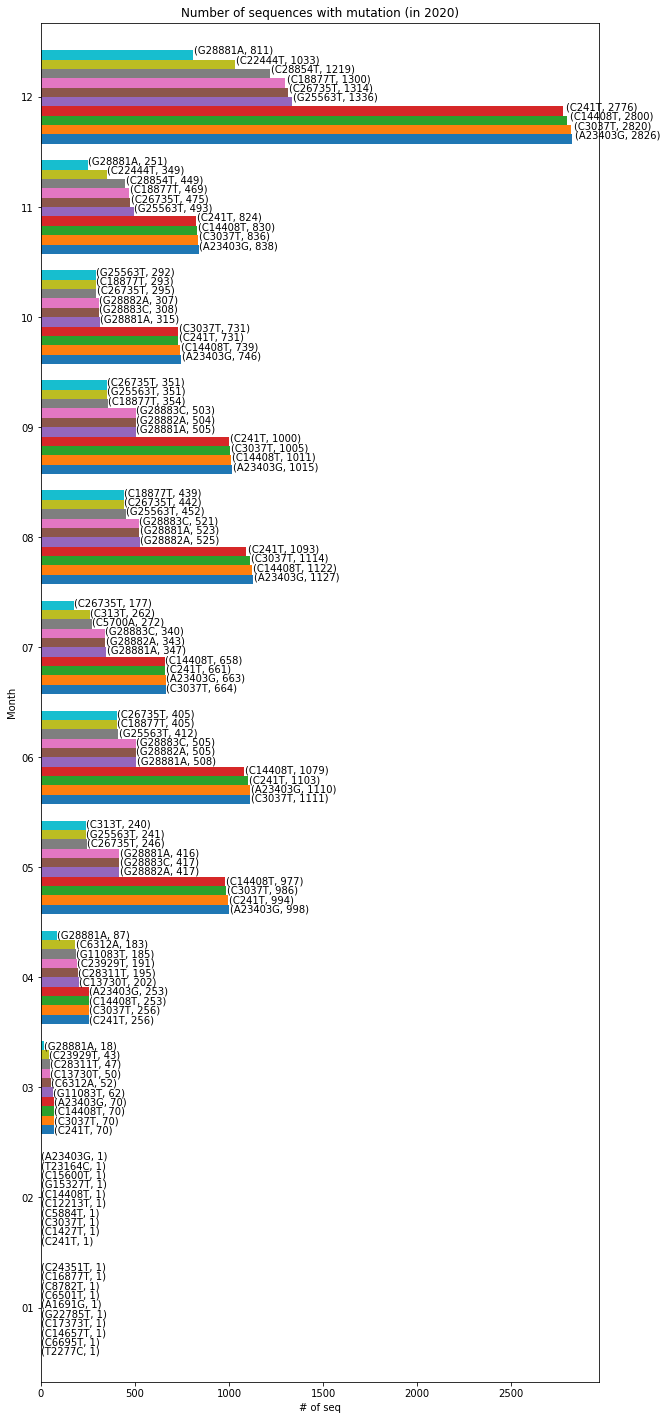

In [47]:
ax = t.plot(figsize=(10, 25), kind='barh', legend=False, width=0.85)
i = 0
ax.set_title(f"Number of sequences with mutation (in {year})")
ax.set_xlabel('# of seq')
ax.set_ylabel('Month')
for p in ax.patches:
    ax.annotate(f'({list(month_mutation_stat[months[i%len(months)]][1].keys())[i//len(months)]}, {p.get_width()})', (p.get_width()*1.005, p.get_y()*1.005))
    i += 1
# ax = t_perc.plot(figsize=(25, 10), kind='bar', legend=False, table=True)

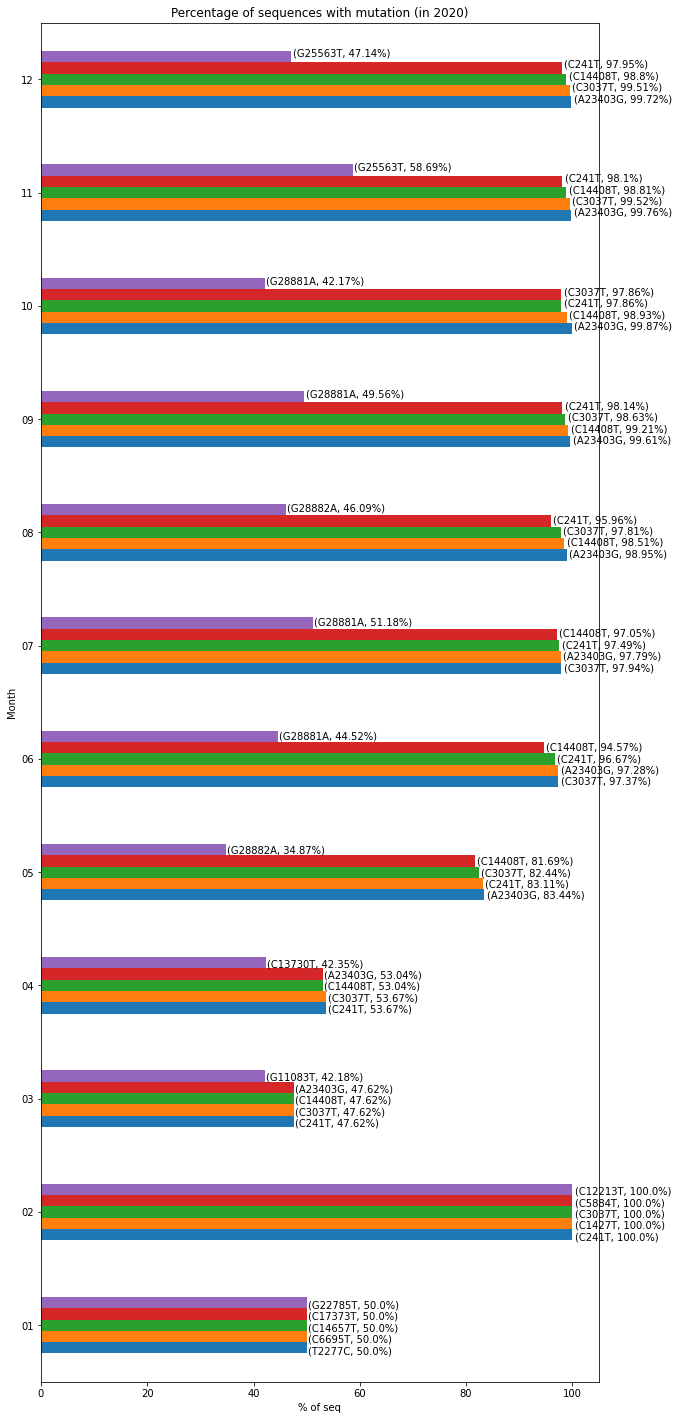

In [143]:
t_perc.index = months
# ax = t.plot(figsize=(10, 25), kind='barh', legend=False, width=0.85)
ax = t_perc.plot(figsize=(10, 25), kind='barh', legend=False)
ax.set_title("Percentage of sequences with mutation")
ax.set_title(f"Percentage of sequences with mutation (in {year})")
ax.set_xlabel('% of seq')
ax.set_ylabel('Month')
i = 0
for p in ax.patches:
    ax.annotate(f'({list(month_mutation_stat[months[i%len(months)]][1].keys())[i//len(months)]}, {round(p.get_width(), 2)}%)', (p.get_width()*1.005, p.get_y()*1.005))
    i += 1

<br>

In [63]:
month_mutation_stat['01'][2]

{'ORF1a': {'I671T': 1, 'P2144S': 1, 'I476V': 1, 'P2079L': 1},
 'ORF1b': {'A397V': 1, 'T1137I': 1},
 'S': {'R408I': 1, 'A930V': 1},
 'ORF8': {'L84S': 1}}

##### AA mutations

In [46]:
AAs = ['S', 'N', 'ORF1a', 'ORF1b', 'ORF3a', 'ORF8', 'ORF9b', 'ORF7a', 'ORF7b', 'M', 'E', 'ORF6']

# \### 4.2

In [124]:
n = 10
writer = pd.ExcelWriter(f'outputs/{year}/4_2_aa_mutMonthly_t{n}.xlsx', engine='xlsxwriter')
for aaR in AAs:
    tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
    for month in months:
        if aaR not in month_mutation_stat[month][2]:
            continue
        muts = list(month_mutation_stat[month][2][aaR].keys())[:n]
        muts.extend([''] * (n - len(muts)))
        ct = list(month_mutation_stat[month][2][aaR].values())[:n]
        ct.extend([0] * (n - len(ct)))
        tdf[month + ' Mut'] = ['', ''] + muts
        tdf[month + ' Count'] = [month_mutation_stat[month][0], ''] + ct
    tdf.to_excel(writer, sheet_name=aaR, index=True)
writer.save()
writer.close()

c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


<br>

In [144]:
lim = 5
month_aa_mut_major = [[]] * len(AAs)
for i in range(len(AAs)):
    mnthMut = []
    for (month, item) in month_mutation_stat.items():
        mut = []
        ct = []
        if AAs[i] in item[2].keys():
            mut = list(item[2][AAs[i]].keys())[:lim]
            ct = list(item[2][AAs[i]].values())[:lim]
        else:
            mut = []
            ct = []
        mnthMut.append([mut, ct])
    # t = [[list(item[2][AAs[i]].keys())[:lim], list(item[2][AAs[i]].values())[:lim]] for (month, item) in month_mutation_stat.items()]
    month_aa_mut_major[i] = mnthMut

In [147]:
## RUN THIS CODE (Helper code for below fragments)
def plotAAMonthWise(month_aa_major_list, index, title, perc = False):

    t = pd.DataFrame(list(pd.DataFrame(month_aa_major_list[index]).loc[slice(None), 1]), columns=np.arange(1, lim+1))
    t.index = months
    # t['Tot'] = [month_mutation_stat[months[i]][0] for i in range(len(months))]
    if perc == True:
        t = t.apply(lambda row : pd.Series([row[i]*100/month_mutation_stat[months[i]][0] for i in range(len(row))]))
        xlabel = '% of seq'
    else:
        xlabel = '# of seq'
    t.replace(np.nan, 0, inplace=True)
    # print(t)
    t.index = months
    ax = t.plot(figsize=(10, 25), kind='barh', legend=False, width=0.85)
    i = 0
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Month')
    for p in ax.patches:
        if p.get_width() != 0:
            ax.annotate(f'({list(month_mutation_stat[months[i%len(months)]][2][AAs[index]].keys())[i//len(months)]} :: {round(p.get_width(), 2)})', (p.get_width()*1.005, p.get_y()*1.005))
        i += 1
    # ax = t_perc.plot(figsize=(25, 10), kind='bar', legend=False, table=True)

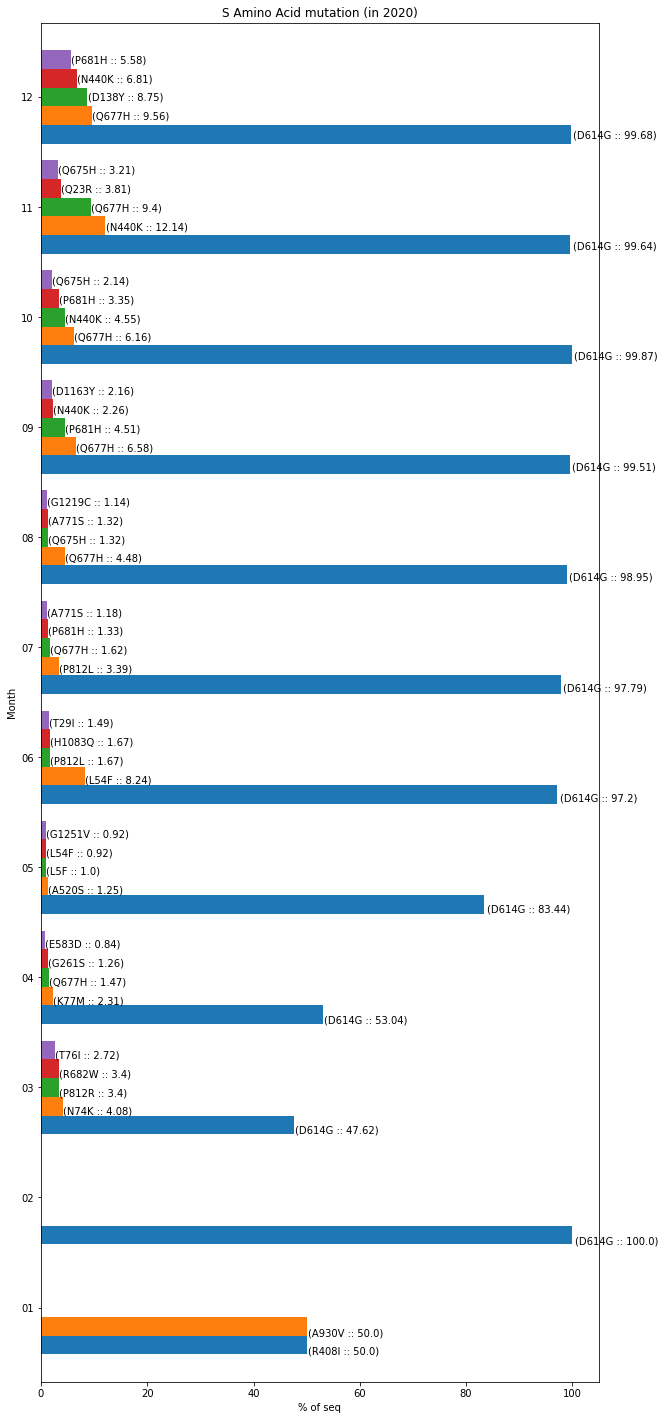

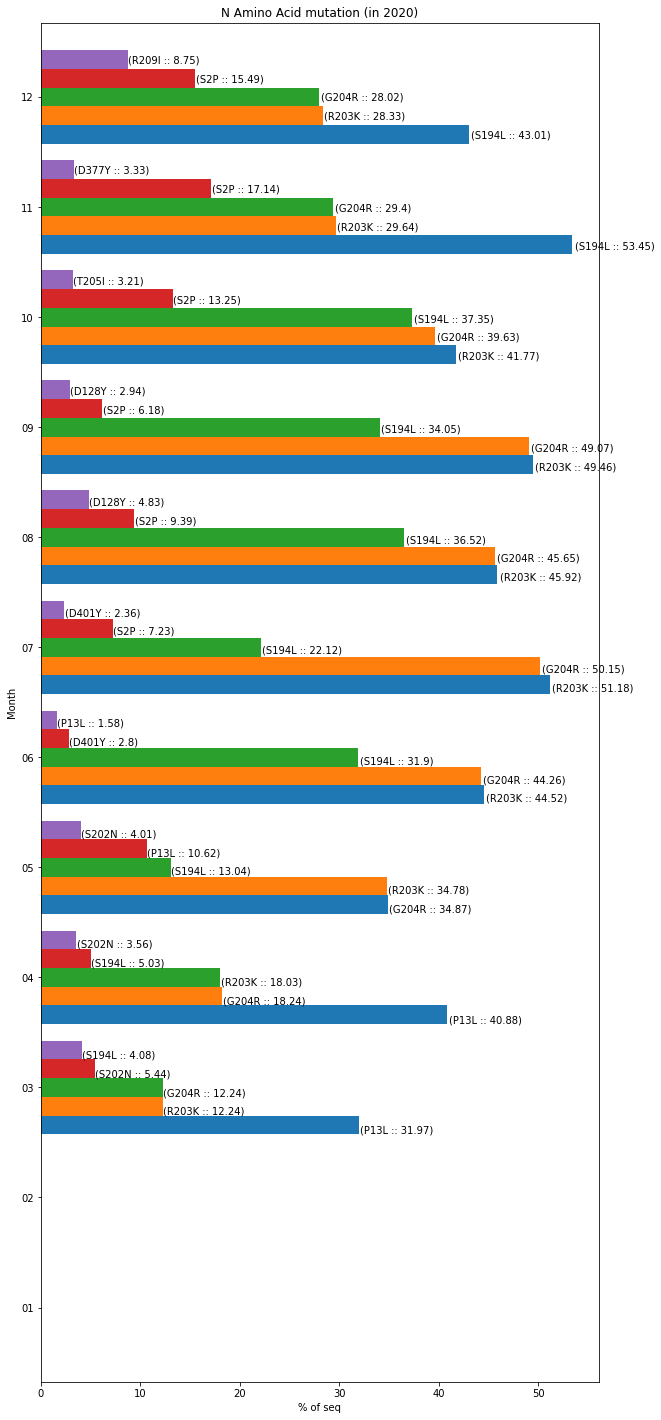

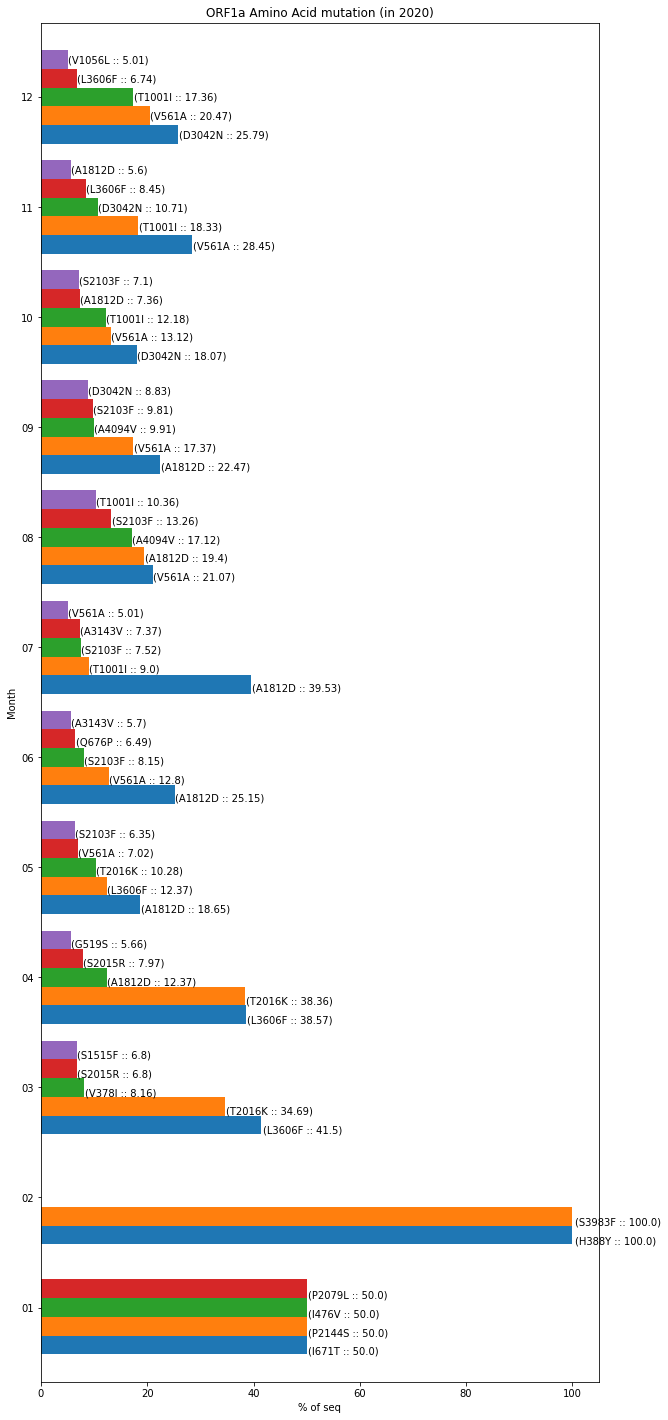

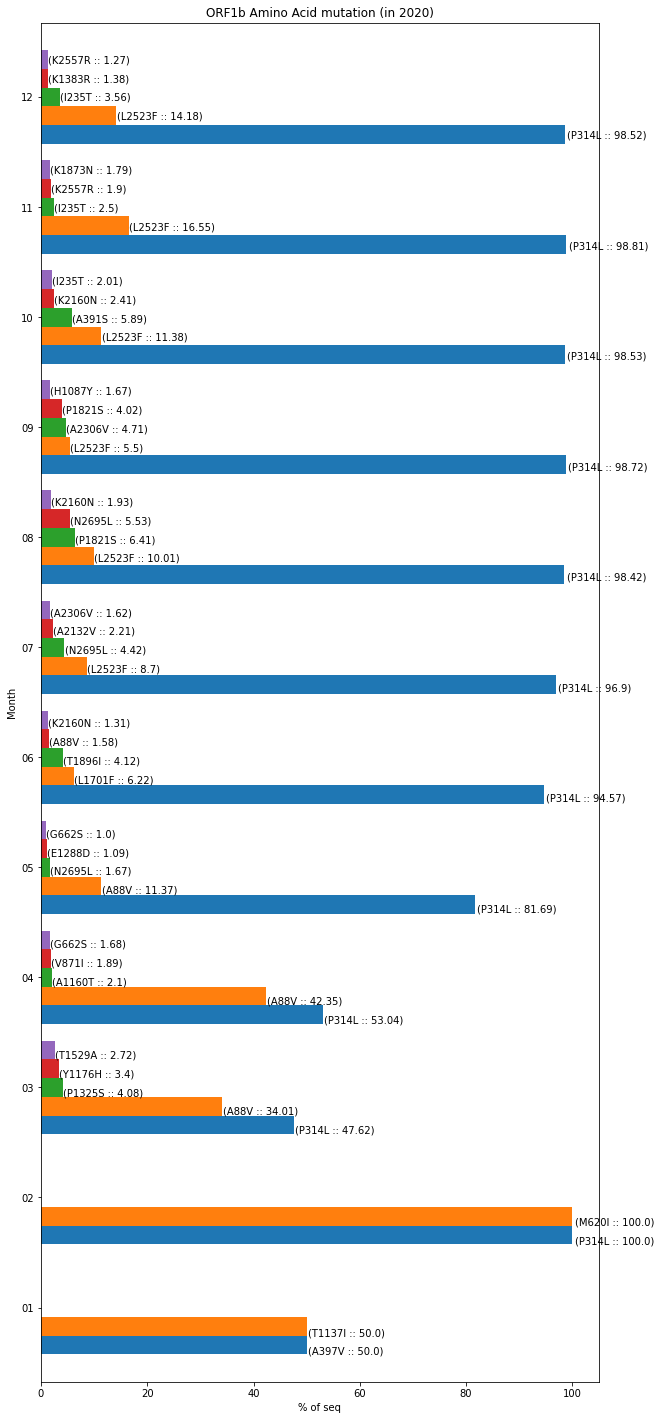

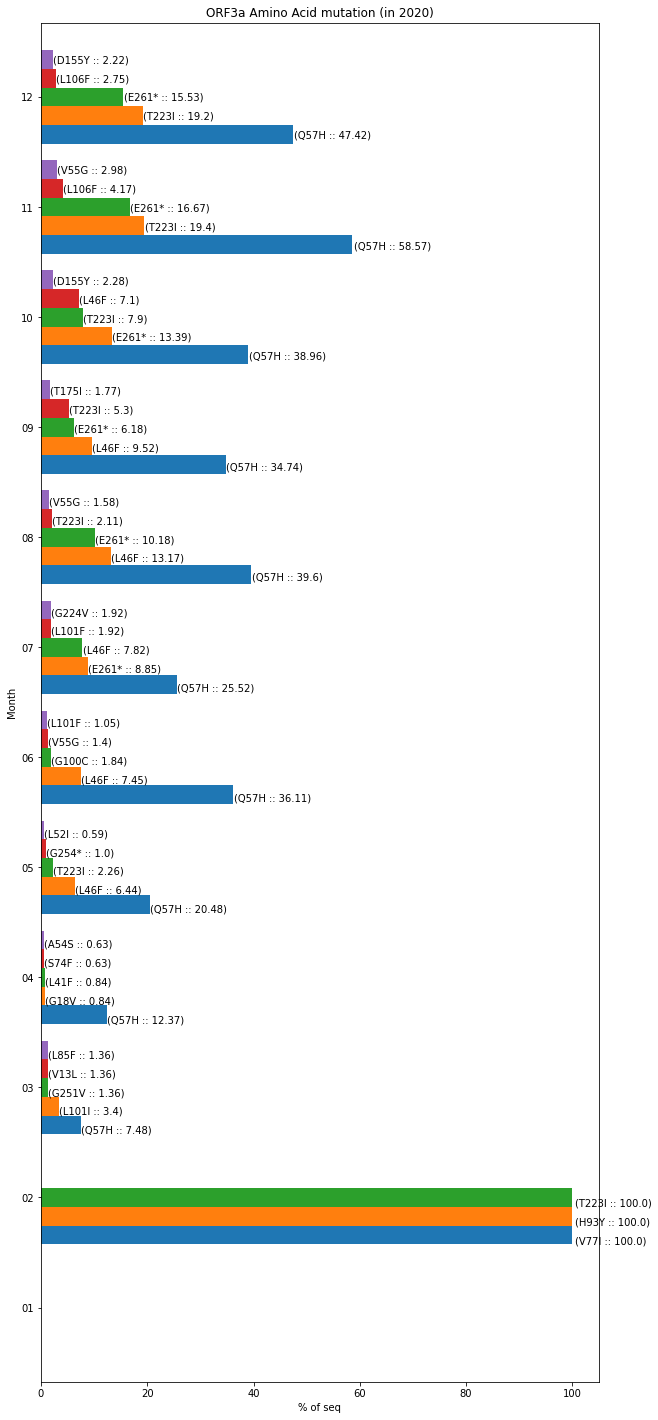

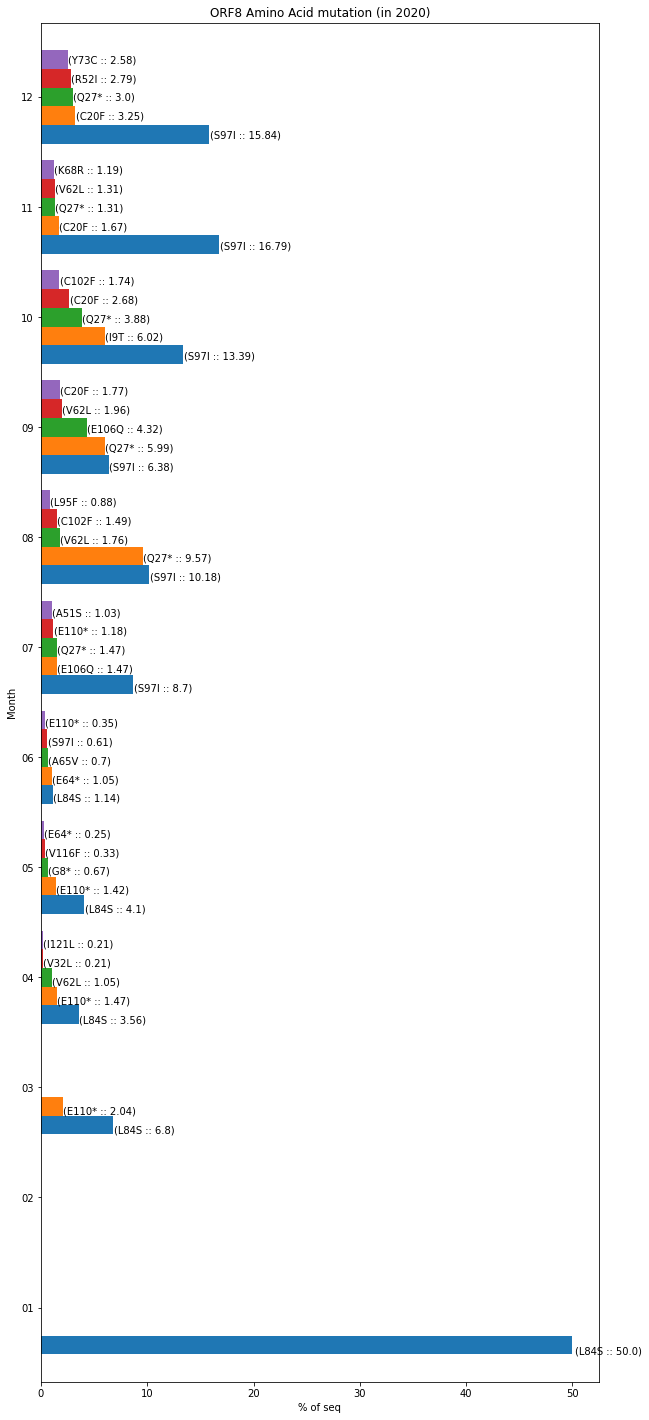

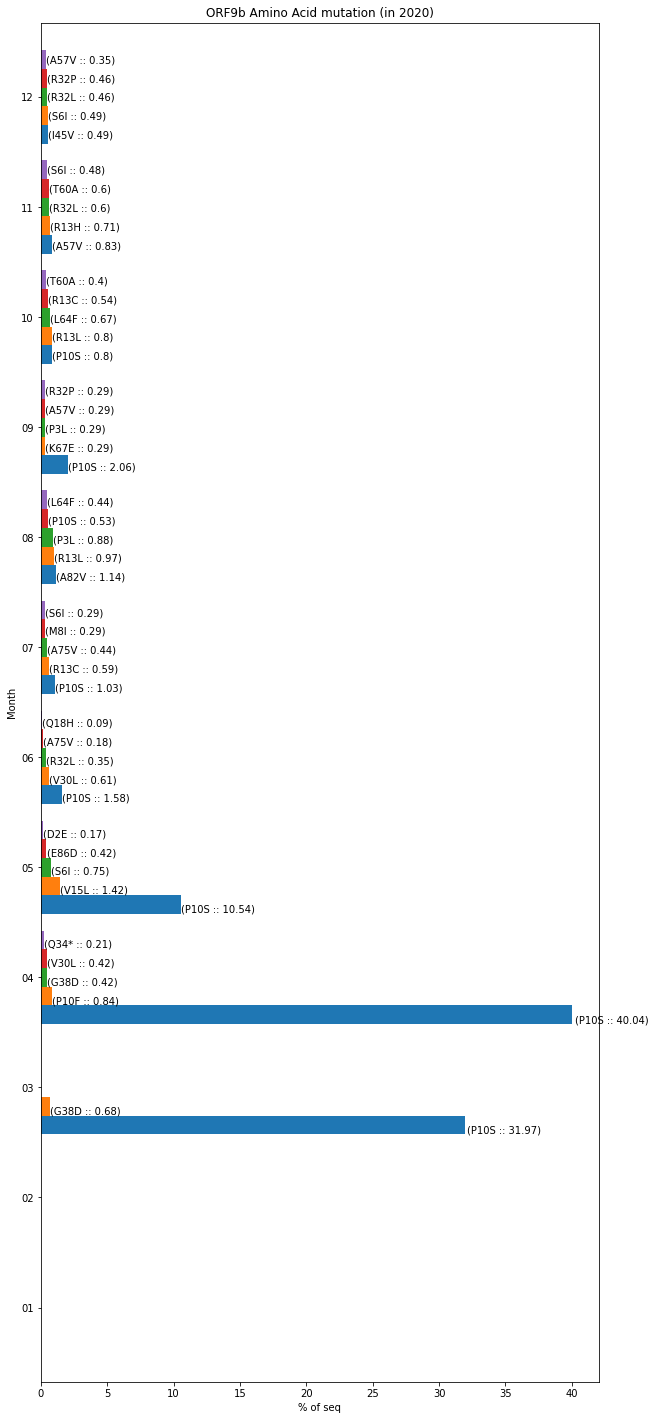

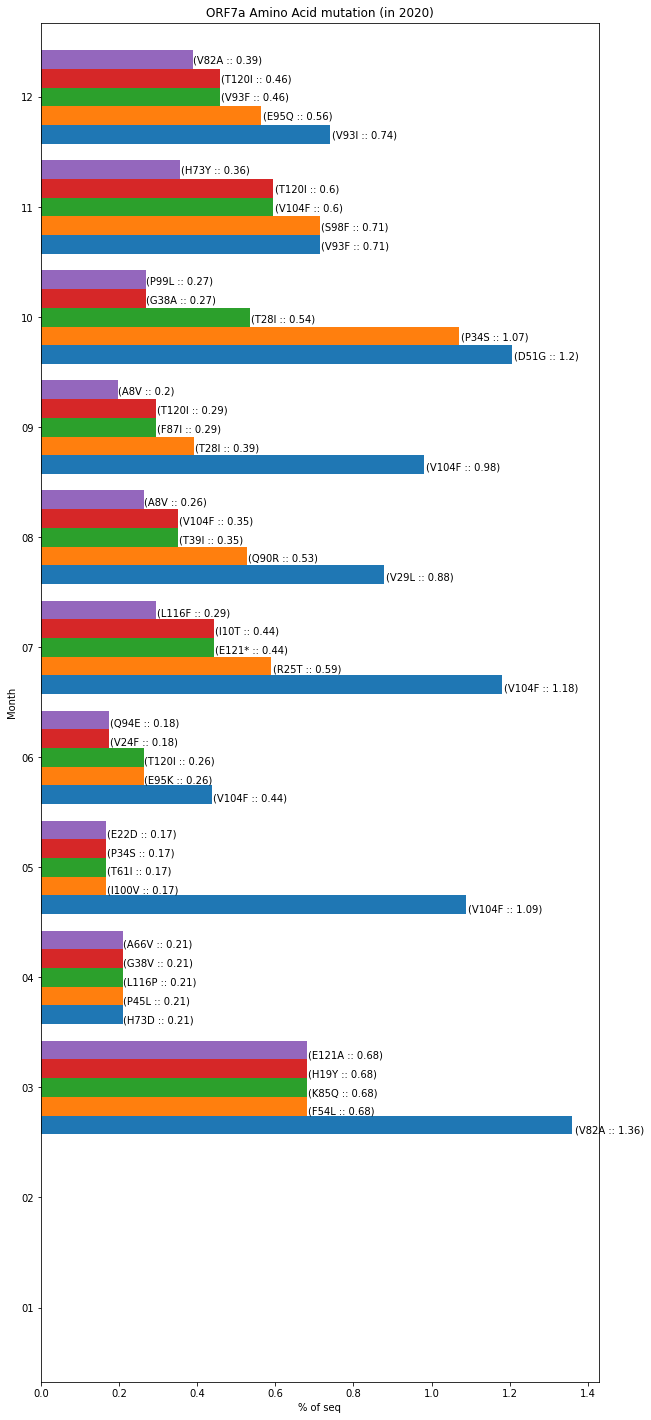

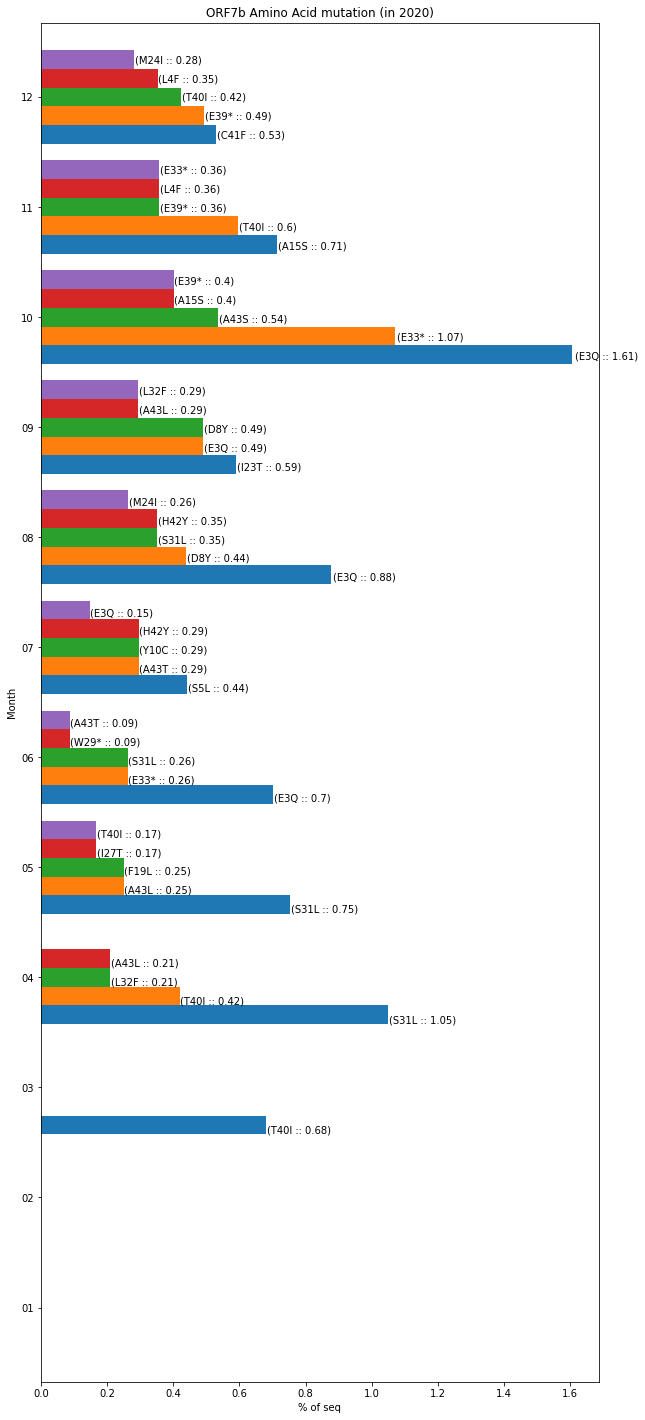

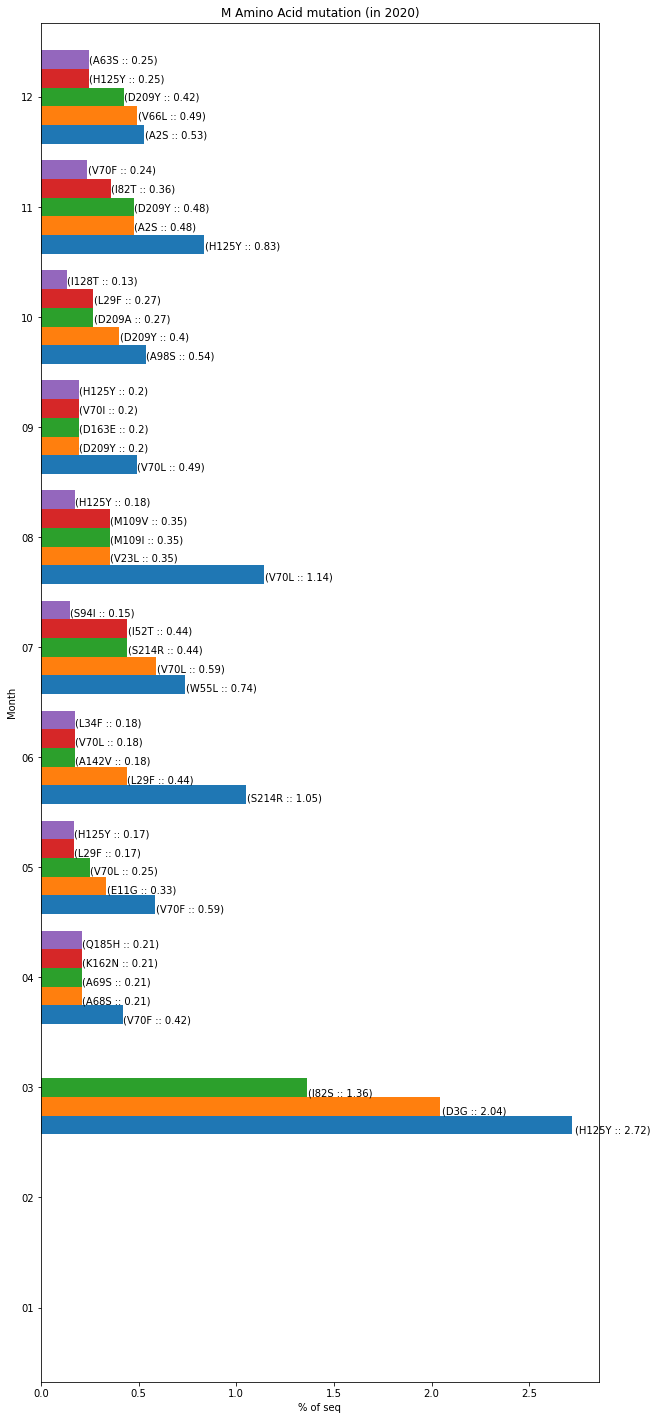

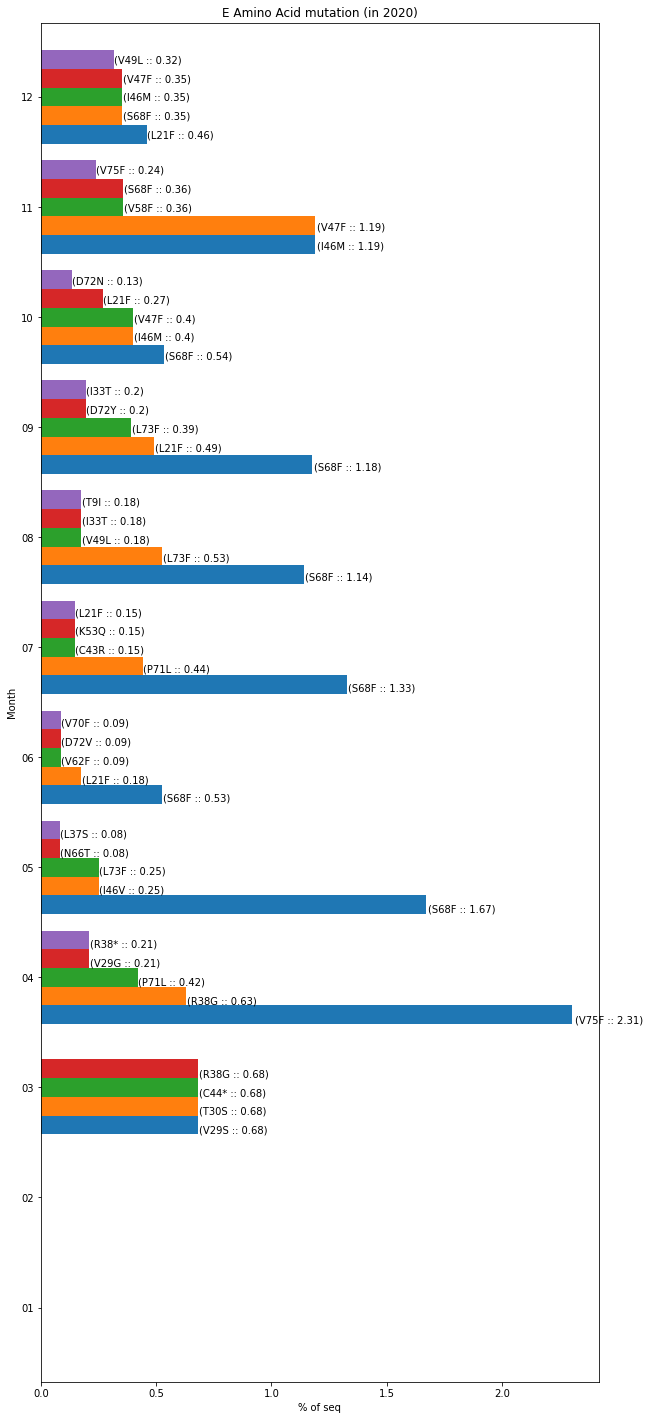

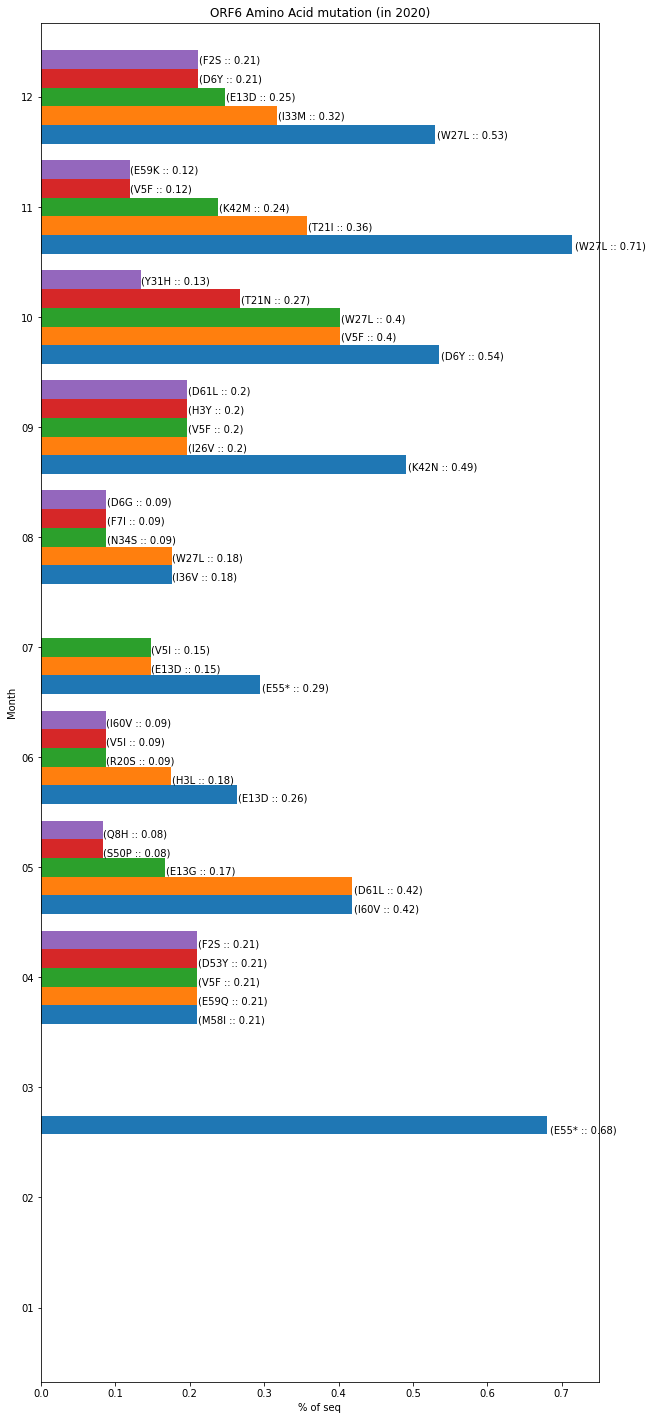

In [148]:
# Plotting the major amino acid mutations monthwise
for i in range(len(AAs)):
    plotAAMonthWise(month_aa_mut_major, i, f'{AAs[i]} Amino Acid mutation (in {year})', perc=True)

<br>

##### Nextclade Pangolineage stat

In [42]:
lim = 5
month_pango_major = [[list(val[3].keys())[:lim],list(val[3].values())[:lim]] for (month, val) in month_mutation_stat.items()]

In [43]:
t = pd.DataFrame(list(pd.DataFrame(month_pango_major).loc[slice(None), 1]), columns=np.arange(1, lim+1))
t.index = months
# t['Tot'] = [month_mutation_stat[months[i]][0] for i in range(len(months))]
t_perc = t.apply(lambda row : pd.Series([row[i]*100/month_mutation_stat[months[i]][0] for i in range(len(row))]))
t.replace(np.nan, 0, inplace=True)
t_perc.replace(np.nan, 0, inplace=True)
t_perc.index = months

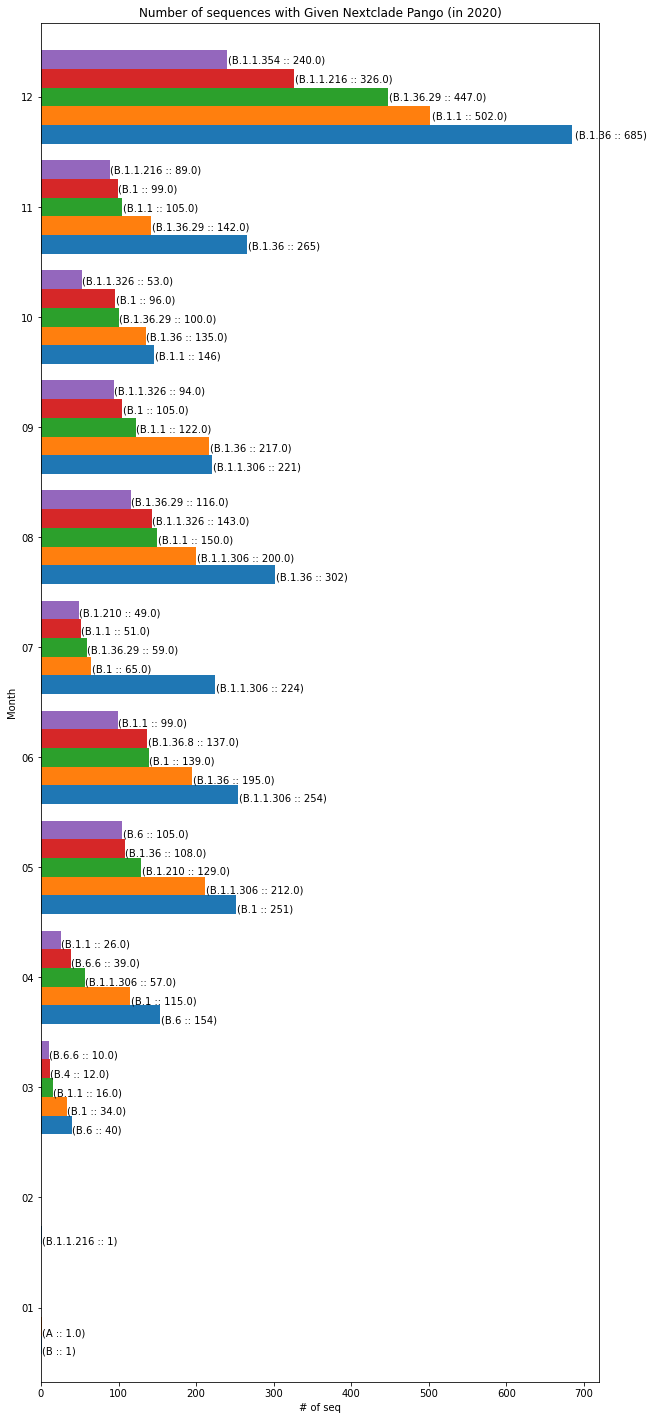

In [48]:
ax = t.plot(figsize=(10, 25), kind='barh', legend=False, width=0.85)
i = 0
ax.set_title(f"Number of sequences with Given Nextclade Pango (in {year})")
ax.set_ylabel('Month')
ax.set_xlabel('# of seq')
for p in ax.patches:
    if p.get_width() != 0:
        ax.annotate(f'({list(month_mutation_stat[months[i%len(months)]][3].keys())[i//len(months)]} :: {p.get_width()})', (p.get_width()*1.005, p.get_y()*1.005))
    i += 1
# ax = t_perc.plot(figsize=(25, 10), kind='bar', legend=False, table=True)

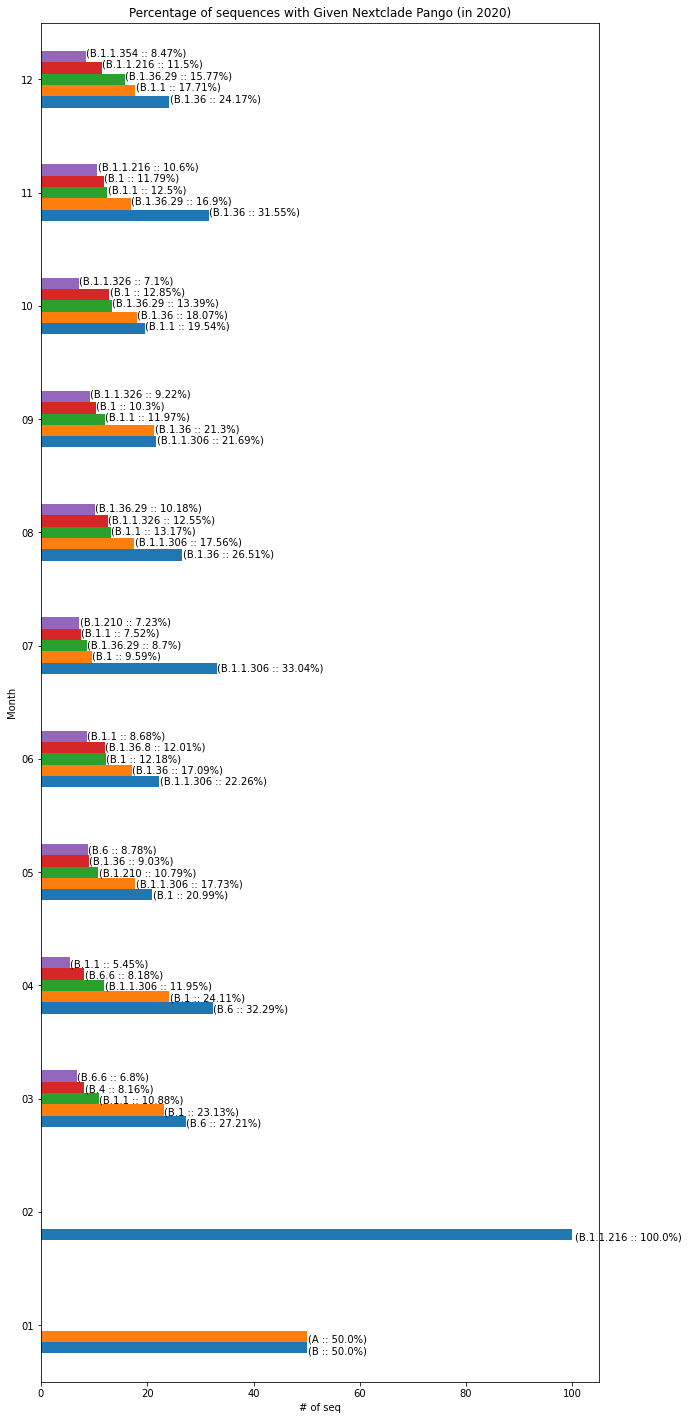

In [47]:
# ax = t.plot(figsize=(10, 25), kind='barh', legend=False, width=0.85)
ax = t_perc.plot(figsize=(10, 25), kind='barh', legend=False)
ax.set_title(f"Percentage of sequences with Given Nextclade Pango (in {year})")
ax.set_ylabel('Month')
ax.set_xlabel('# of seq')
i = 0
for p in ax.patches:
    if p.get_width() != 0:
        ax.annotate(f'({list(month_mutation_stat[months[i%len(months)]][3].keys())[i//len(months)]} :: {round(p.get_width(), 2)}%)', (p.get_width()*1.005, p.get_y()*1.005))
    i += 1

<br><br><br><br><br><br>

### Region-Wise

In [49]:
# mut_master_df
# metas # metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')


In [10]:
new_meta = metas.copy()

In [11]:
new_meta.index = new_meta.division
zones_metas_df = []
for i in range(len(zones)):
    t = new_meta.filter(regex=zonesRegex[i], axis=0)
    t.index = t.loc[slice(None), t.columns[0]]
    zones_metas_df.append(t)

In [12]:
for reg, tlen in zip(zones, [item.shape[0] for item in zones_metas_df]):
    print(reg, tlen, sep=' : ')

India : 0
Northern Zone : 21484
Central Zone : 6573
Eastern Zone : 15306
Western Zone : 23068
Southern Zone : 47399
North Eastern Zone : 10168
Others : 0


In [13]:
tdict = dict(zones_metas_df[1]['submitting_lab'].value_counts())
pd.DataFrame(tdict.items(), columns=['Name', 'Count'])

,Name,Count
0,"NCDC Delhi, Biotechnology Division -INSACOG",10498
1,"NCDC Delhi, Biotechnology Division INSACOG",3771
2,INSACOG at CSIR Institute of Genomics and Inte...,2376
3,NIV Influenza,1632
4,ILBS,1564
5,"NCDC Delhi, Biotechnology Division",402
6,CDFD -INSACOG,223
7,CSIR-Centre for Cellular and Molecular Biology...,151
8,The Institute of Liver and Biliary Sciences (I...,136
9,Regional Level Viral Research and Diagnostic L...,128


<br>

# \### 6.1

In [14]:
writer = pd.ExcelWriter(f'outputs/{year}/6_1_sl_allreg.xlsx', engine='xlsxwriter')
tdict = dict(metas['submitting_lab'].value_counts())
tdf = pd.DataFrame(tdict.items(), columns=['Name', 'Count'])
nr = pd.DataFrame({'Name' : ' ', 'Count': len(metas)}, index=[0])
tdf = pd.concat([nr,tdf]).reset_index(drop=True)
tdf.to_excel(writer, sheet_name='India', index=True)
for i in range(len(zones)):
    if len(zones_metas_df[i]) == 0:
        continue
    tdict = dict(zones_metas_df[i]['submitting_lab'].value_counts())
    tdf = pd.DataFrame(tdict.items(), columns=['Name', 'Count'])
    nr = pd.DataFrame({'Name' : ' ', 'Count': len(zones_metas_df[i])}, index=[0])
    tdf = pd.concat([nr,tdf]).reset_index(drop=True)
    tdf.to_excel(writer, sheet_name=zones[i], index=True)
writer.save()
writer.close()

c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [79]:
zonal_mut_master = []
for i in range(len(zones)):
    zonal_mut_master.append(merg)

3025

<br>

##### Preprocessings

In [19]:
# metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')
# mut_master_df

In [22]:
reg_mutation_stat = func_region_mut_stat(metas, mut_master_df)

#### Nucleotide

In [ ]:
lim = 10
reg_nuc_mut_major = [[list(val[1].keys())[:lim],list(val[1].values())[:lim]] for (reg, val) in reg_mutation_stat.items()]

# \### 3.3


In [44]:
# DOC_SAVE      Nuc mut monthly overall
n = 10
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for zone in zones:
    muts = list(reg_mutation_stat[zone][1].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(reg_mutation_stat[zone][1].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[zone + ' Mut'] = ['', ''] + muts
    tdf[zone + ' Count'] = [reg_mutation_stat[zone][0], ''] + ct
tdf.to_csv(f'outputs/{year}/3_3_nuc_mutZoneW_t10.csv')

In [23]:
# Temp # DOC_SAVE      Nuc mut monthly overall
n = 300
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for zone in zones:
    muts = list(reg_mutation_stat[zone][1].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(reg_mutation_stat[zone][1].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[zone + ' Mut'] = ['', ''] + muts
    tdf[zone + ' Count'] = [reg_mutation_stat[zone][0], ''] + ct
tdf.to_csv(f'outputs/{year}/3_3_nuc_mutZoneW_t300.csv')

# \### 5.3


In [29]:
# DOC_SAVE      Nuc mut monthly overall
n = 10
tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
for zone in zones:
    muts = list(reg_mutation_stat[zone][3].keys())[:n]
    muts.extend([''] * (n - len(muts)))
    ct = list(reg_mutation_stat[zone][3].values())[:n]
    ct.extend([0] * (n - len(ct)))
    tdf[zone + ' Pango'] = ['', ''] + muts
    tdf[zone + ' Count'] = [reg_mutation_stat[zone][0], ''] + ct
tdf.to_csv(f'outputs/{year}/5_3_pangoZoneW_t10.csv')

<br>

# \### 4.3

In [47]:
n = 10
writer = pd.ExcelWriter(f'outputs/{year}/4_3_aa_mutZoneW_t{n}.xlsx', engine='xlsxwriter')
for aaR in AAs:
    tdf = pd.DataFrame(index = ['Total', ''] + list(range(1, n+1)))
    for z in zones:
        if aaR not in reg_mutation_stat[z][2]:
            continue
        muts = list(reg_mutation_stat[z][2][aaR].keys())[:n]
        muts.extend([''] * (n - len(muts)))
        ct = list(reg_mutation_stat[z][2][aaR].values())[:n]
        ct.extend([0] * (n - len(ct)))
        tdf[z + ' Mut'] = ['', ''] + muts
        tdf[z + ' Count'] = [reg_mutation_stat[z][0], ''] + ct
    tdf.to_excel(writer, sheet_name=aaR, index=True)
writer.save()
writer.close()

c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


<br><br><br><br><br><br>

### Daily Cases

##### 1. Indian Source

In [29]:
daily_cases_df = pd.read_csv(r'data/DailyCases/case_time_series.csv', sep=',')

In [30]:
daily_cases_df.drop('Date', axis=1, inplace=True)
daily_cases_df.rename(columns={'Date_YMD': 'Date'}, inplace=True)

In [31]:
t_daily_cases_df = daily_cases_df.set_index(keys=daily_cases_df['Date'])

In [32]:
monthly_cases = []
for month in months:
    dateReg = year + '-' + month
    monthly_cases.append(t_daily_cases_df.filter(regex=dateReg, axis=0)['Daily Confirmed'].sum())

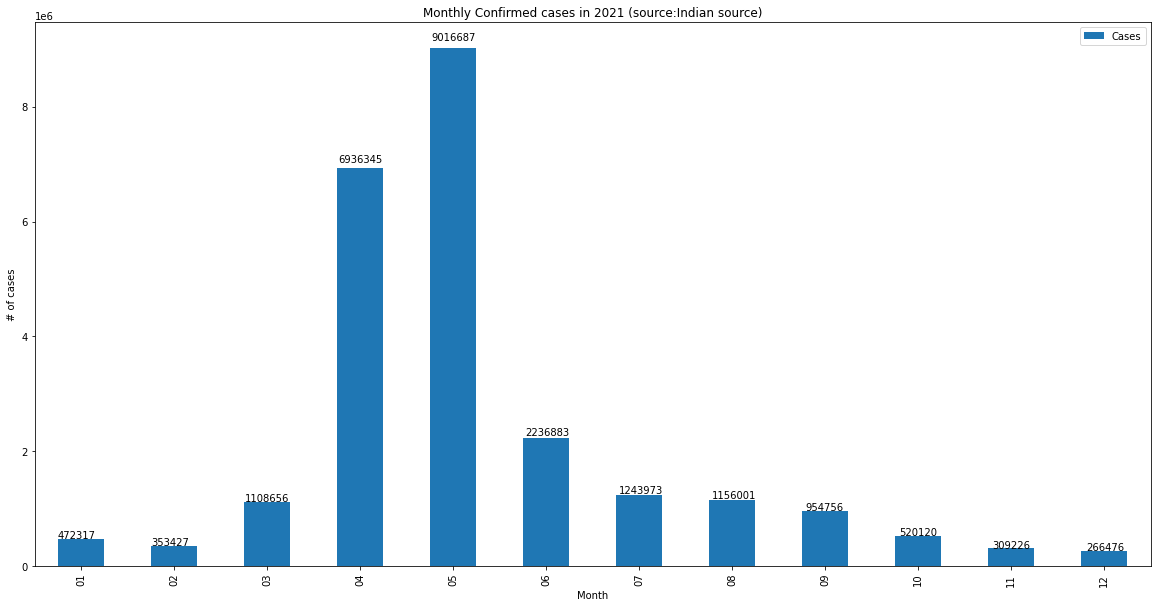

In [48]:
plot1D(monthly_cases, months, title=f"Monthly Confirmed cases in {year} (source:Indian source)", ylabel='# of cases', xlabel='Month')

2. WHO as source


In [34]:
daily_cases_who = pd.read_csv(r'data/DailyCases/who_ind.csv', sep=',')
daily_cases_who = daily_cases_who[daily_cases_who['source'] == 'WHO']
daily_cases_who.reset_index(inplace=True)
daily_cases_who.drop('index', axis=1, inplace=True)
t_daily_cases_who = daily_cases_who.set_index(keys=daily_cases_who['date'])

In [61]:
t_df = t_daily_cases_who.filter(regex=f'{str(int(year)-1)}-12', axis=0)['cases']

In [65]:
t_df[-1]

10244852

In [66]:
monthly_cases_who = []
monthly_cases_who.append(int(t_df[-1]))
for month in months:
    dateReg = year + '-' + month
    t_df = t_daily_cases_who.filter(regex=dateReg, axis=0)['cases']
    monthly_cases_who.append(t_df[-1] - sum(monthly_cases_who))
monthly_cases_who.pop(0)

10244852

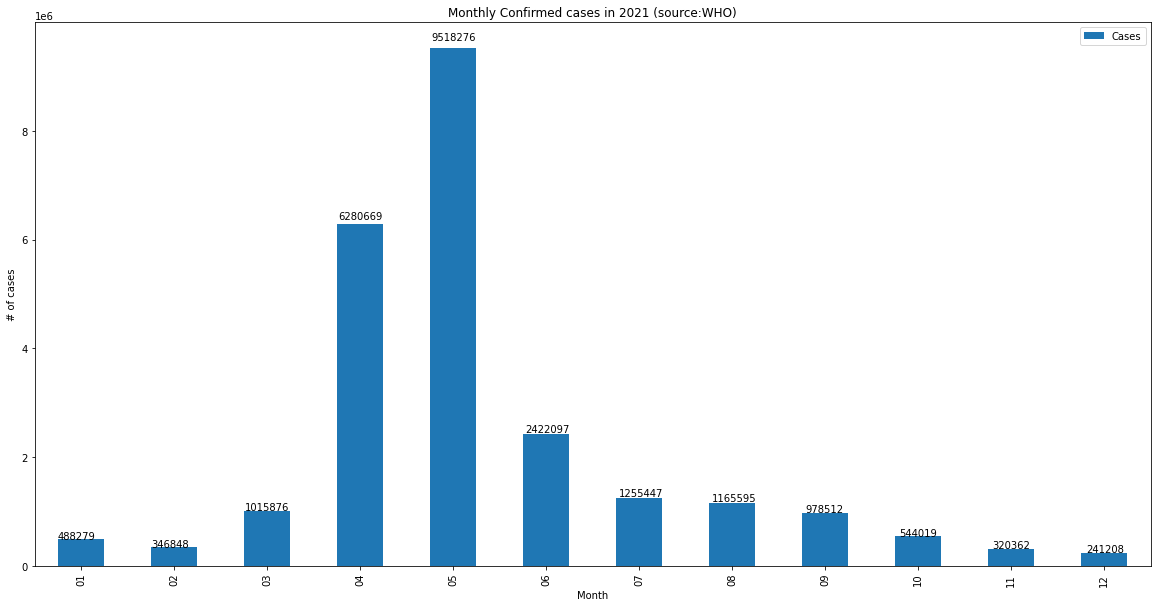

In [67]:
plot1D(monthly_cases_who, months, title=f"Monthly Confirmed cases in {year} (source:WHO)", ylabel='# of cases', xlabel='Month')

# \### 1

In [68]:
pd.DataFrame({'Month' : months, 'Covid19India' : monthly_cases, 'WHO' : monthly_cases_who}).to_csv(f'outputs/{year}/1_monthly_cases.csv', index=False)

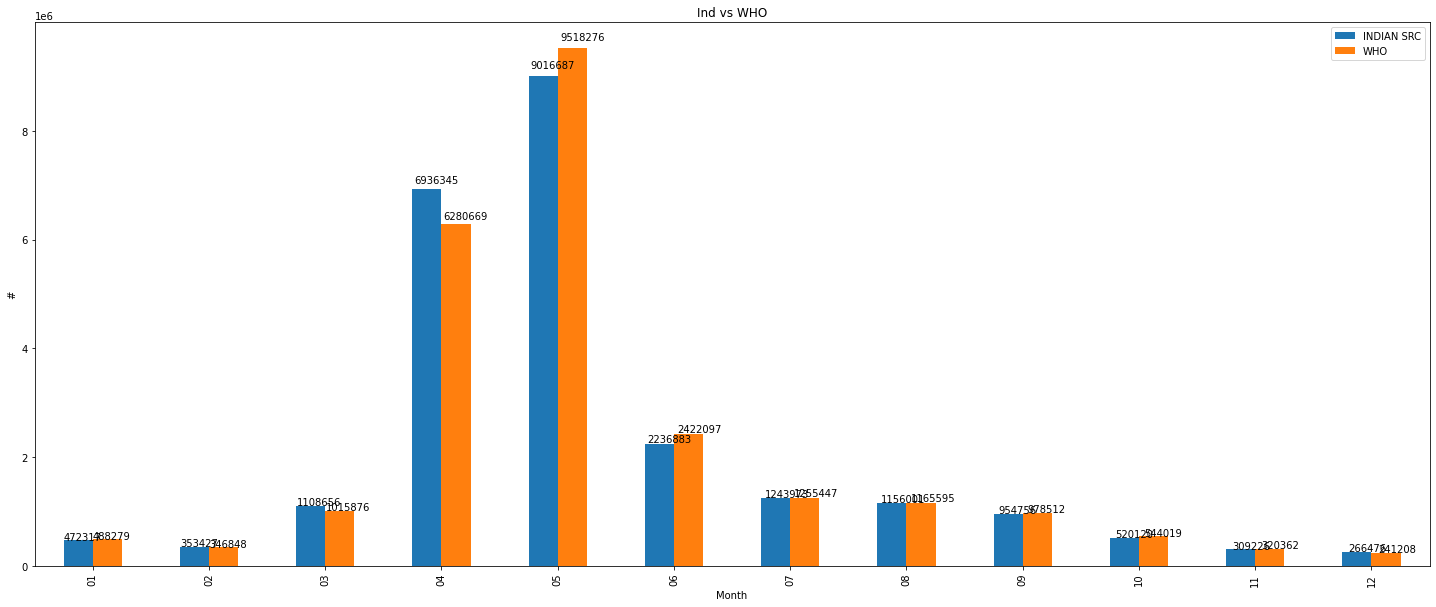

In [69]:
plot2Ddict({f'INDIAN SRC' : monthly_cases, 'WHO': monthly_cases_who}, months, 'Ind vs WHO', '#', 'Month')

<br><br><br><br><br>

##### No. of cases vs No. of sequences

In [59]:
# monthly_cases_who     # from previous part
# mut_master_df         # from beginning of file


In [28]:
new_meta = metas.set_index(keys=metas['date'])

In [29]:
len(metas.filter(regex=f'{year}-01', axis=0))

0

In [30]:
monthly_seq_count = []
for month in months:
    dateReg = year + '-' + month
    monthly_seq_count.append(len(new_meta.filter(regex=dateReg, axis=0)))

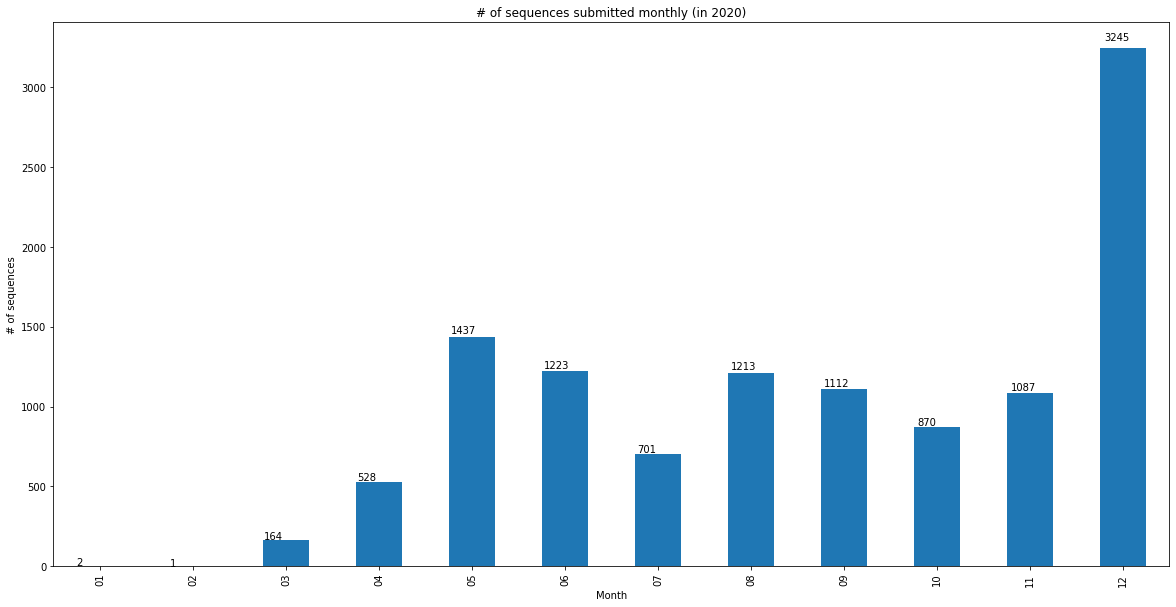

In [31]:
plot1D(monthly_seq_count, months, f'# of sequences submitted monthly (in {year})', f'# of sequences', 'Month', bool_legend=False)

<br>

In [ ]:
# monthly_cases_who
# monthly_seq_count

In [37]:
perM = 1000000
perTT = 10000
perT = 1000
perH = 100

In [57]:
# divisor = perT
# pd.DataFrame({f'Cases/{divisor}' : [int(it/divisor) for it in monthly_cases_who], 'Seq': monthly_seq_count}, index=months).plot(kind='bar', figsize=(25, 10))

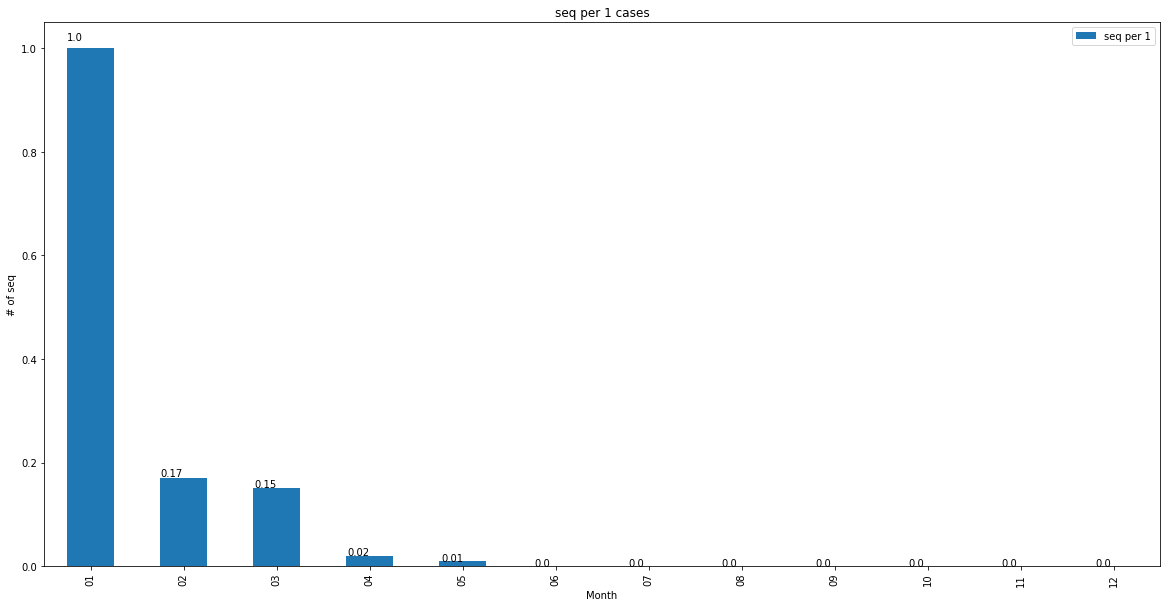

In [38]:
divisor = 1
plot1D([round(min(seq/case, 1)*divisor, 2) for case, seq in zip(monthly_cases_who, monthly_seq_count)], months, f'seq per {divisor} cases', f'# of seq', 'Month', f'seq per {divisor}', True)

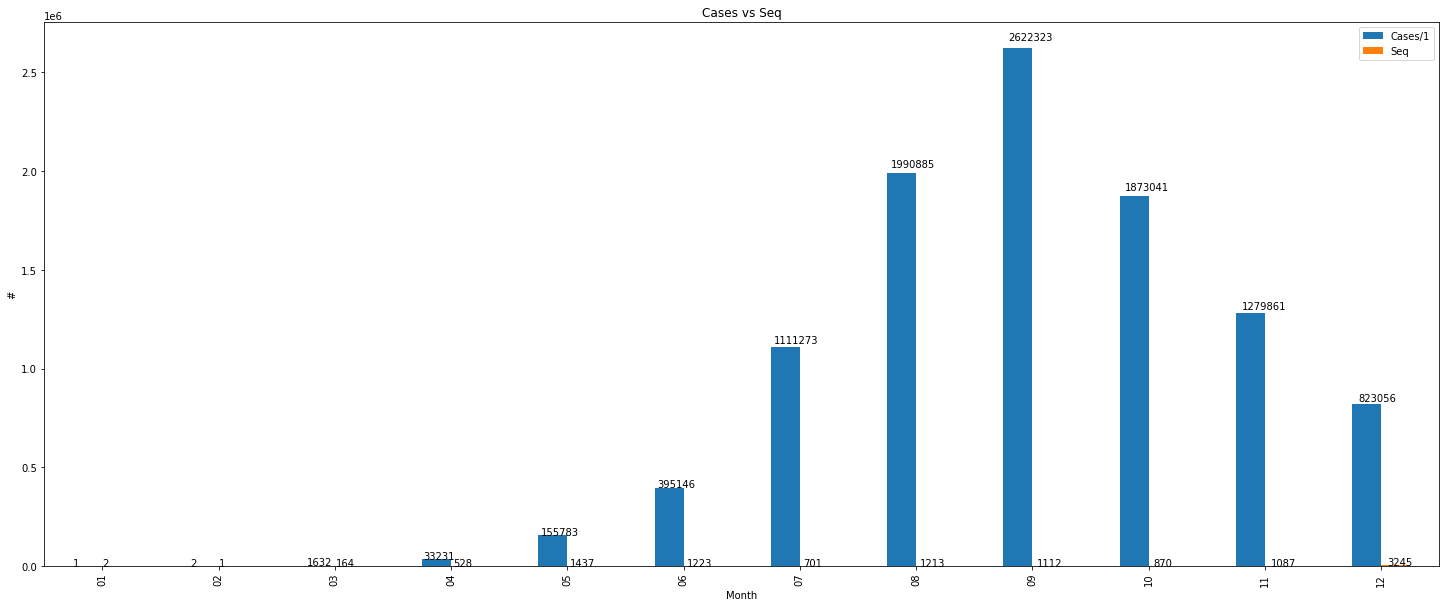

In [40]:
divisor = 1
plot2Ddict({f'Cases/{divisor}' : [int(it/divisor) for it in monthly_cases], 'Seq': monthly_seq_count}, months, 'Cases vs Seq', '#', 'Month')

<br><br><br><br><br><br>

## Monthly cases vs seq

In [72]:
metas = pd.read_csv(rawSeqCombPath + 'all.tsv', sep='\t')

In [73]:
new_meta = metas.set_index(keys=metas['date'])

In [74]:
len(metas.filter(regex=f'{year}-05', axis=0))

0

In [75]:
monthly_seq_count = []
for month in months:
    dateReg = year + '-' + month
    monthly_seq_count.append(len(new_meta.filter(regex=dateReg, axis=0)))

# \### 2.1

In [77]:
pd.DataFrame({'Month' : months, 'Monthly cases' : monthly_cases, 'Monthly seq' : monthly_seq_count}).to_csv(f'outputs/{year}/2_1_casesvsseq.csv', index=False)

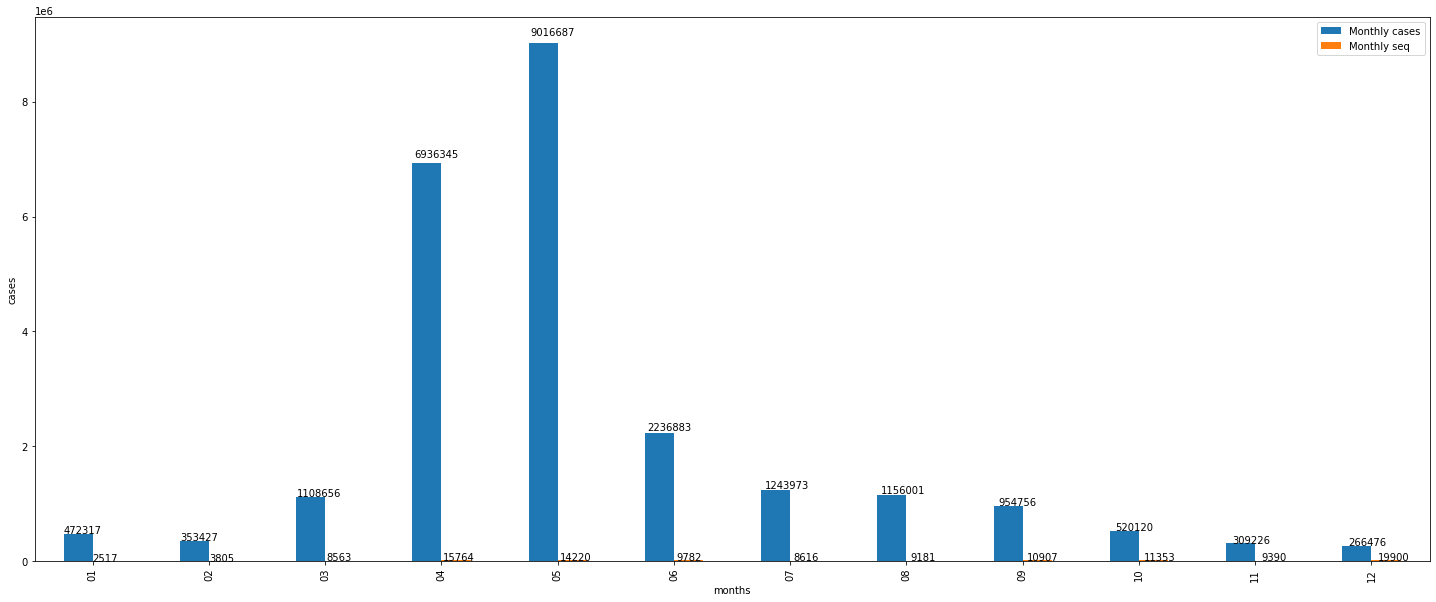

In [82]:
plot2Ddict({'Monthly cases' : monthly_cases, 'Monthly seq' : monthly_seq_count}, index=months, title = '', ylabel='cases', xlabel='months')

<br><br><br><br><br><br>

### Daily Cases Region Wise

##### Reading data on daily cases state wise

In [22]:
rWise_daily_cases_df = pd.read_csv(r'data/DailyCases/states.csv', sep=',')

In [23]:
rWise_daily_cases_df['YYYY-MM'] = rWise_daily_cases_df.apply(lambda x : str(x.Date)[:7], axis=1)

In [24]:
tState = rWise_daily_cases_df.set_index(keys=[rWise_daily_cases_df.State, rWise_daily_cases_df['YYYY-MM']])
tState.drop_duplicates(subset=['State', 'YYYY-MM'], keep='last', inplace=True)
tState.drop(['Date', 'State', 'YYYY-MM'], axis=1, inplace=True)

In [49]:
# tState.loc[(slice(None), '2020-07'), 'Confirmed'].sum() - tState.loc[
#     ('India', '2020-07'), 'Confirmed'].sum() - tState.loc[('State Unassigned', '2020-07'), 'Confirmed'
#     ].sum(), tState.loc[('India', '2020-07'), 'Confirmed'].sum()

(1697054, 1697054)

In [25]:
zonalCasesMonthWise = []
zonalCasesMonthWise.append([0, 0, 0, 0, 0, 0, 0, 0])
prevsum = [0, 0, 0, 0, 0, 0, 0, 0]
tlist = []
for i in range(len(zones)):
    # tdf = tState.filter(regex = zonesRegex[i], axis=0)
    yyyymm = str(int(year)-1) + '-' + months[-1]
    try:
        tres = (tState.filter(regex=zonesRegex[i], axis=0)).loc[(slice(None) , yyyymm), 'Confirmed'].sum()
    except KeyError:
        tres = 0
    tlist.append(max(0, tres-prevsum[i]))
    prevsum[i] = tres
zonalCasesMonthWise.append(tlist)

In [26]:
for month in months:
    tlist = []
    for i in range(len(zones)):
        # tdf = tState.filter(regex = zonesRegex[i], axis=0)
        yyyymm = year + '-' + month
        try:
            tres = (tState.filter(regex=zonesRegex[i], axis=0)).loc[(slice(None) , yyyymm), 'Confirmed'].sum()
        except KeyError:
            tres = 0
        tlist.append(max(0, tres-prevsum[i]))
        prevsum[i] = tres
    zonalCasesMonthWise.append(tlist)
del zonalCasesMonthWise[0]
del zonalCasesMonthWise[0]

In [27]:
print('All', 'India')
for idx in range(len(months)):
    print(sum(zonalCasesMonthWise[idx][1:]), zonalCasesMonthWise[idx][0], zonalCasesMonthWise[idx])

All India
472317 472317 [472317, 38526, 59655, 34892, 113148, 223199, 2897, 0]
353428 353428 [353428, 22812, 17938, 10312, 138605, 162687, 1074, 0]
1108660 1108660 [1108660, 128575, 87458, 22768, 699012, 169367, 1480, 0]
6936479 6936479 [6936479, 1180437, 1362569, 658727, 2086617, 1600302, 47827, 0]
9016687 9016687 [9016687, 1311672, 1047603, 1209621, 1453045, 3752782, 241964, 0]
2236885 2236885 [2236885, 100443, 58171, 291198, 340172, 1276683, 170218, 0]
1243973 1243973 [1243973, 18343, 13770, 100188, 248212, 710068, 153392, 0]
1156005 1156005 [1156005, 18862, 4521, 52634, 164528, 829956, 85504, 0]
954755 954755 [954755, 12635, 2287, 39801, 88977, 746078, 64977, 0]
520110 520110 [520110, 10394, 1735, 39497, 62548, 362272, 43664, 0]
309227 309227 [309227, 10856, 1659, 31427, 25088, 217228, 22969, 0]
266475 266475 [266475, 19786, 4225, 31300, 50588, 148441, 12135, 0]


In [28]:
zonalCasesMonthWiseGraph = [list(x) for x in zip(*zonalCasesMonthWise)]

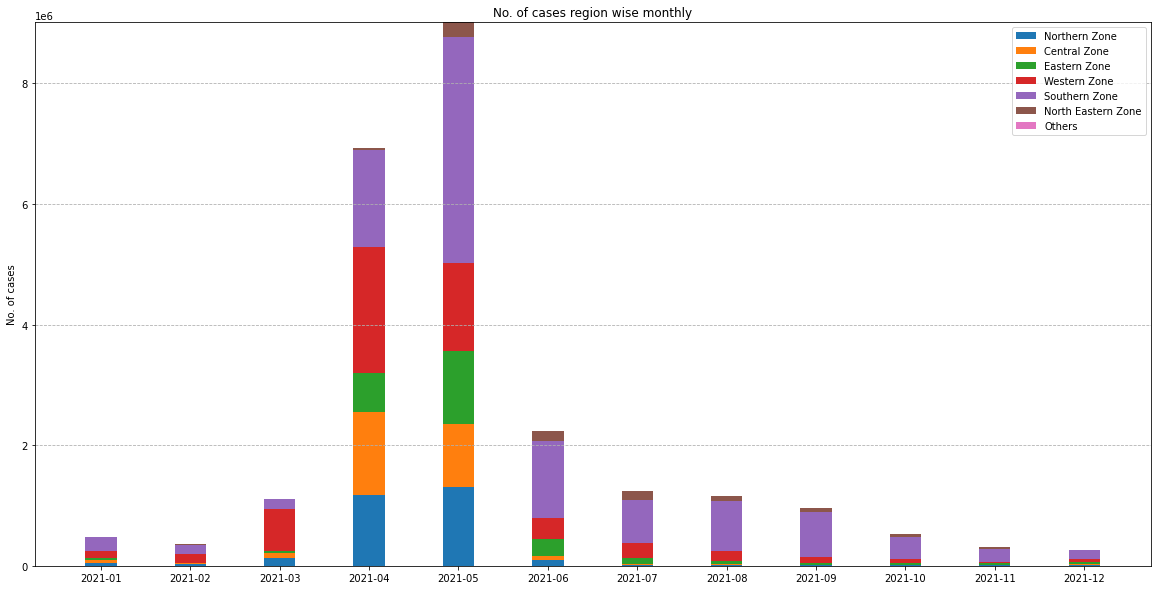

In [99]:
# Plotting monthly cases regionwise (Stacked)
labels = [year + '-' + month for month in months]
width = 0.35

fig, ax = plt.subplots(figsize=(20,10))
# ax.bar(labels, zonalCasesMonthWiseGraph[0], width, label=zones[0])
ax.bar(labels, zonalCasesMonthWiseGraph[1], width, label=zones[1])
tsum = zonalCasesMonthWiseGraph[1]
for i in range(2, len(zones)):
    ax.bar(labels, zonalCasesMonthWiseGraph[i], width, label=zones[i], bottom=tsum)
    tsum = [a+b for a,b in zip(tsum, zonalCasesMonthWiseGraph[i])]

ax.set_ylabel('No. of cases')
ax.set_title('No. of cases region wise monthly')
ax.legend()
ax.grid(axis='y', linestyle='--')

plt.show()

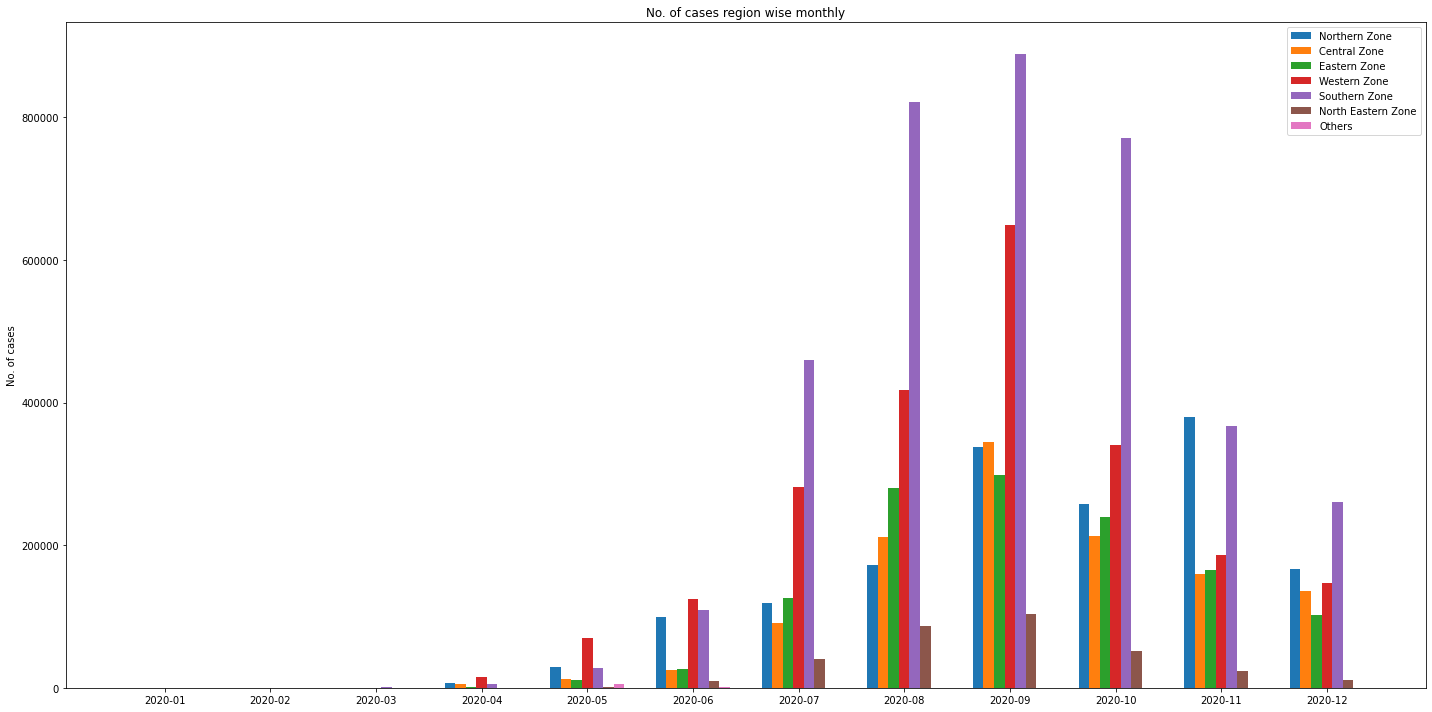

In [74]:
# Plotting monthly cases regionwise (Grouped)
labels = [year + '-' + month for month in months]
width = 0.1
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(20,10))
# ax.bar(labels, zonalCasesMonthWiseGraph[0], width, label=zones[0])
ax.bar(x - 3 * width, zonalCasesMonthWiseGraph[1], width, label=zones[1])
ax.bar(x - 2 * width, zonalCasesMonthWiseGraph[2], width, label=zones[2])
ax.bar(x - width, zonalCasesMonthWiseGraph[3], width, label=zones[3])
ax.bar(x, zonalCasesMonthWiseGraph[4], width, label=zones[4])
ax.bar(x + width, zonalCasesMonthWiseGraph[5], width, label=zones[5])
ax.bar(x + 2 * width, zonalCasesMonthWiseGraph[6], width, label=zones[6])
ax.bar(x + 3 * width, zonalCasesMonthWiseGraph[7], width, label=zones[7])

ax.set_ylabel('No. of cases')
ax.set_title('No. of cases region wise monthly')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

<AxesSubplot:>

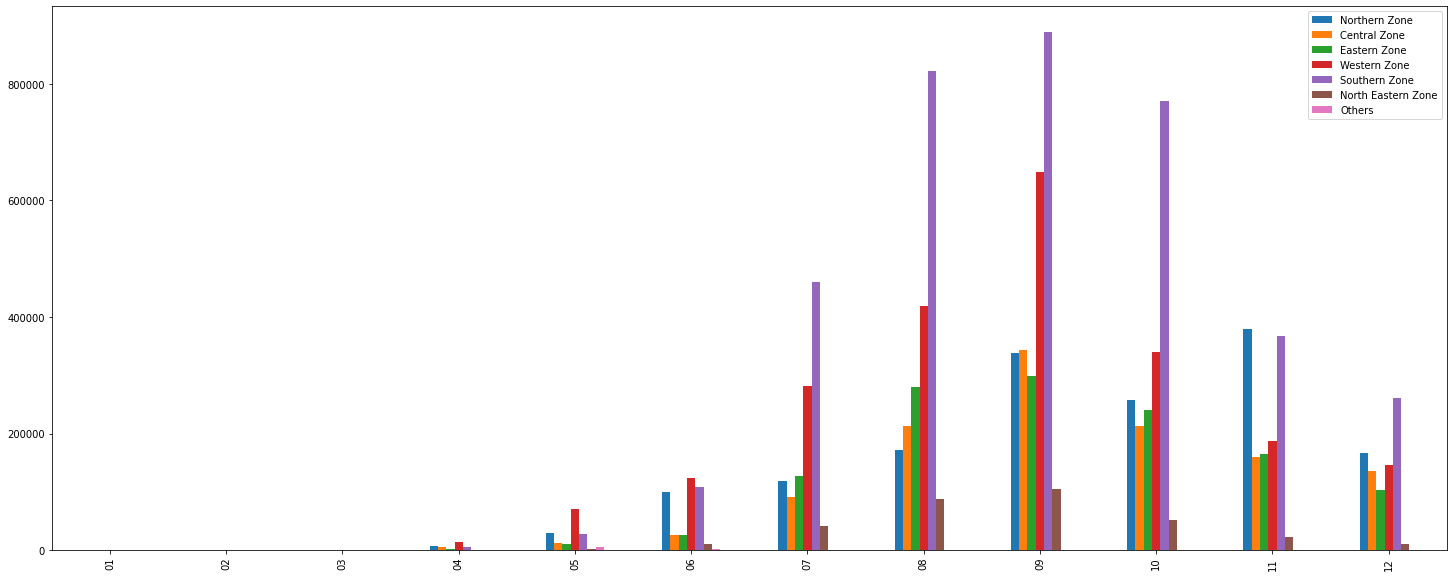

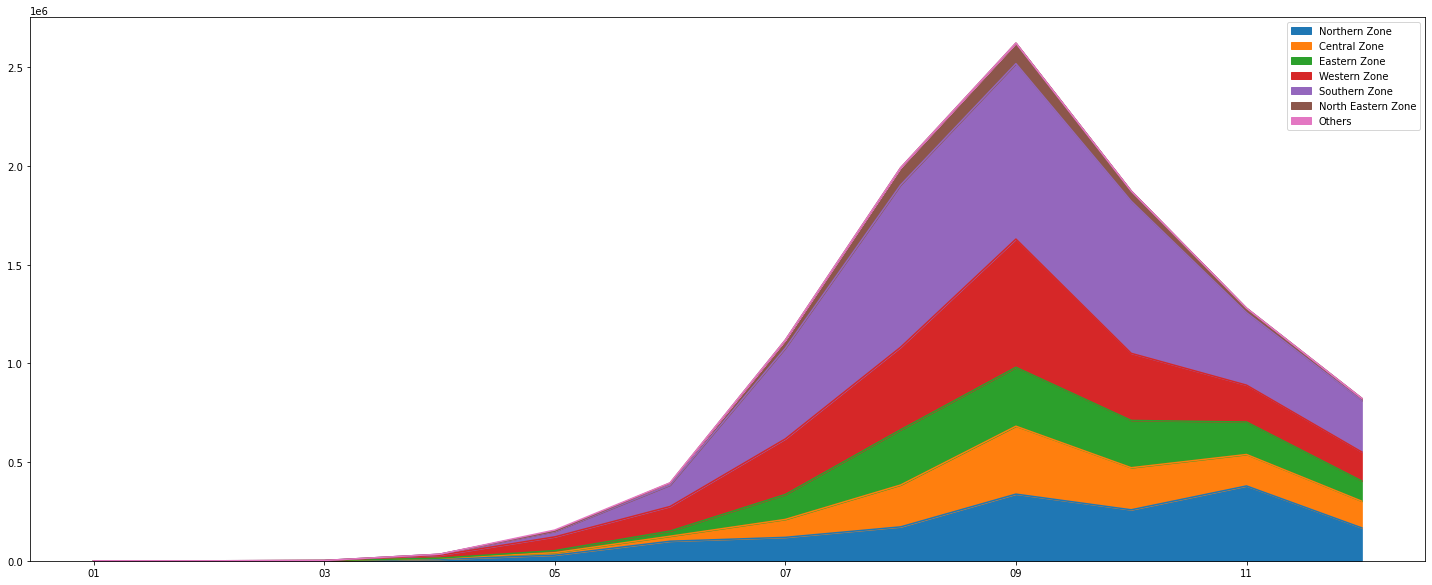

In [75]:
zonaltdf = pd.DataFrame(zonalCasesMonthWise, columns=zones)
zonaltdf.drop('India', axis=1, inplace=True)
zonaltdf.index = months
zonaltdf.plot(figsize=(25, 10), kind='bar', sharex=True, use_index=True)
zonaltdf.plot(kind='area', figsize=(25, 10))

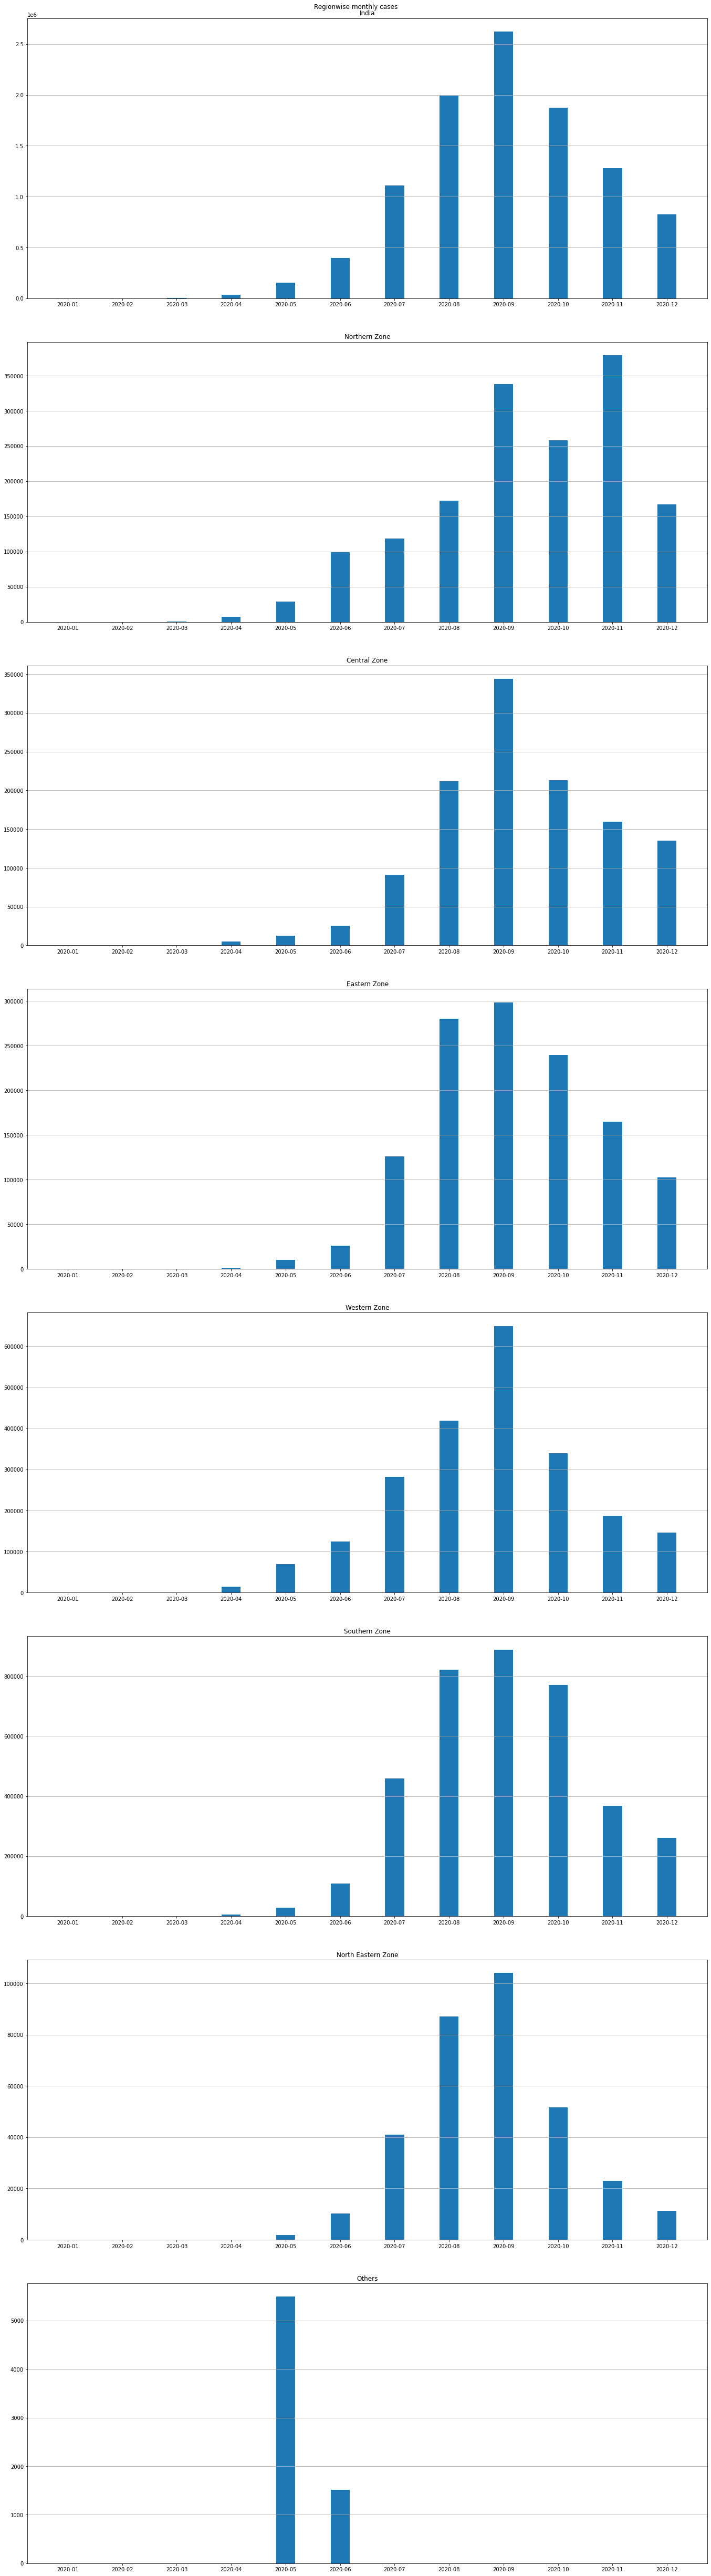

In [76]:
# Regionwise plotting cases

labels = [year+'-'+month for month in months]
width = 0.35

n = len(zones)
fig = plt.figure(figsize=(20, 70))
for i in range(n):
    ax = fig.add_subplot(n, 1, i+1)
    ax.bar(labels, zonalCasesMonthWiseGraph[i], width)
    ax.set_title(zones[i])
    ax.grid(axis='y')
fig.suptitle("Regionwise monthly cases")
fig.tight_layout(pad=5)

<br><br>

##### No. of cases vs No. of sequences

In [11]:
yyyymm = year + '-' + month
t = metas.filter(regex=yyyymm, axis=0)
t.index = t.division
# t.filter(regex=zonesRegex[2], axis=0).shape[0]
# t.filter(regex=)
zonalSeqCount = [t.filter(regex=zone, axis=0).shape[0] for zone in zonesRegex]
zonalSeqCount

NameError: name 'month' is not defined

In [19]:
# zonalCasesMonthWise
# metas
metas['YYYY-MM'] = metas.apply(lambda x : str(x.date)[:7], axis=1)
metas.set_index(keys=metas['YYYY-MM'], inplace=True)
zonalSeqMonthWise = []
zonalSeqMonthWise_df = []
for month in months:
    yyyymm = year + '-' + month
    t = metas.filter(regex=yyyymm, axis=0)
    t.index = t.division
    zonalSeqMonthWise_df.append([t.filter(regex=zone, axis=0) for zone in zonesRegex])
    zonalSeqMonthWise.append([t.filter(regex=zone, axis=0).shape[0] for zone in zonesRegex])


In [20]:
zonalSeqMonthWiseGraph = [list(x) for x in zip(*zonalSeqMonthWise)]

In [29]:
zones[0], zonalCasesMonthWiseGraph[0], zonalSeqMonthWiseGraph[0]

('India',
 [472317,
  353428,
  1108660,
  6936479,
  9016687,
  2236885,
  1243973,
  1156005,
  954755,
  520110,
  309227,
  266475],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# \### 2.2

In [30]:
writer = pd.ExcelWriter(f'outputs/{year}/2_2_casesvsseq_rw.xlsx', engine='xlsxwriter')
for i in range(len(zones)):
    pd.DataFrame({'Month' : months, 'Monthly Cases': zonalCasesMonthWiseGraph[i], 'Monthly Seq': zonalSeqMonthWiseGraph[i]}).to_excel(writer, sheet_name=zones[i], index=False)
writer.save()

In [55]:
zonalSeqMonthWise_df[0][4].columns
# print(zonalSeqMonthWise_df[0][4].pangolin_lineage)
# zonalSeqMonthWise_df[0][4].strain
# zonalSeqMonthWise_df[0][4].Nextstrain_clade
# zonalSeqMonthWise_df[0][4].GISAID_clade

Index(['Unnamed: 0', 'strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'date', 'region', 'country', 'division', 'location', 'region_exposure',
       'country_exposure', 'division_exposure', 'segment', 'length', 'host',
       'age', 'sex', 'Nextstrain_clade', 'pangolin_lineage', 'GISAID_clade',
       'originating_lab', 'submitting_lab', 'authors', 'url', 'title',
       'paper_url', 'date_submitted', 'purpose_of_sequencing', 'YYYY-MM'],
      dtype='object')

<br>

##### Number of sequences per region month wise

In [95]:
zonalSeqMonthWiseGraph

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 51, 78, 384, 202, 11, 85, 273, 334, 492, 1114],
 [0, 0, 14, 35, 91, 37, 13, 67, 14, 6, 14, 36],
 [0, 0, 23, 74, 256, 53, 13, 47, 100, 160, 57, 99],
 [2, 0, 40, 191, 412, 611, 361, 177, 238, 25, 159, 560],
 [0, 0, 34, 149, 290, 317, 236, 449, 355, 286, 316, 1375],
 [0, 0, 2, 1, 4, 3, 67, 388, 132, 59, 49, 61],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

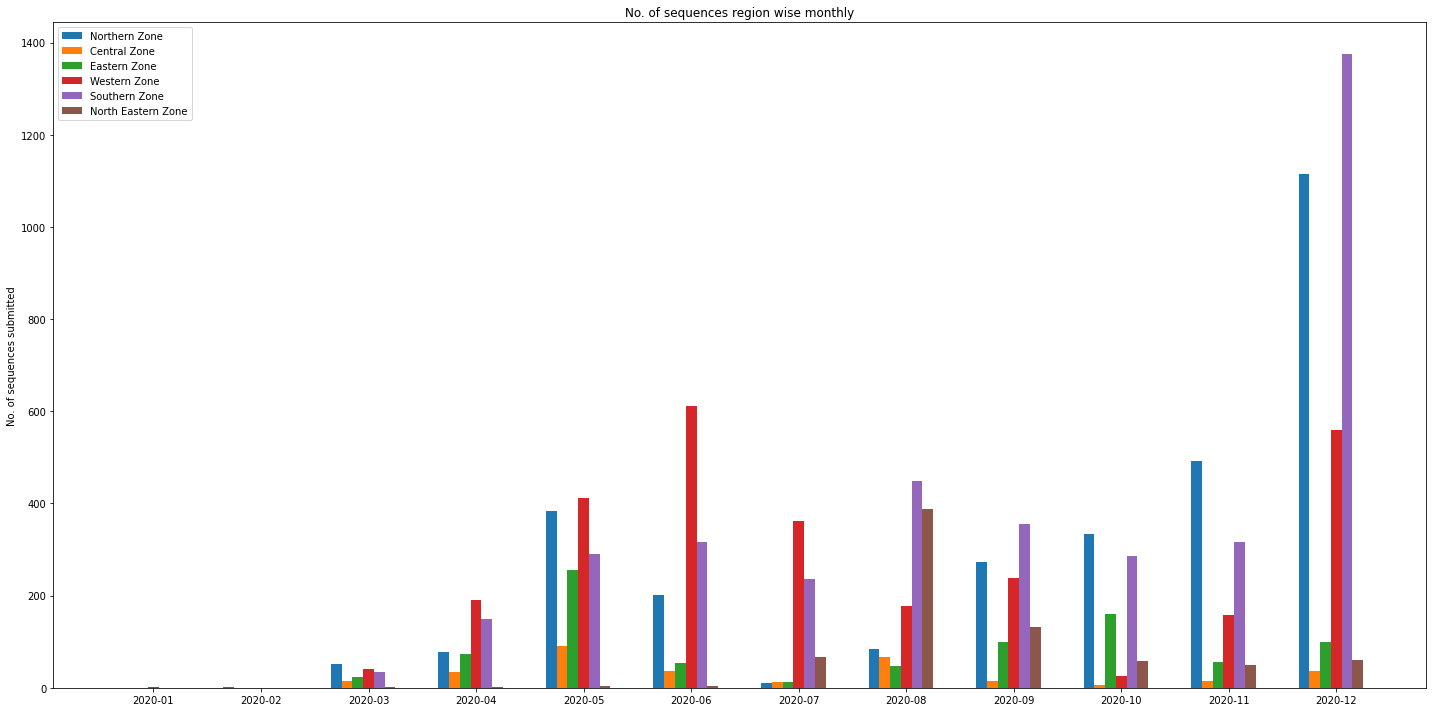

In [270]:
# Plotting monthly Sequences regionwise (Grouped)
labels = [year + '-' + month for month in months]
width = 0.1
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(20,10))
# ax.bar(labels, zonalSeqMonthWiseGraph[0], width, label=zones[0])
ax.bar(x - 3 * width, zonalSeqMonthWiseGraph[1], width, label=zones[1])
ax.bar(x - 2 * width, zonalSeqMonthWiseGraph[2], width, label=zones[2])
ax.bar(x - width, zonalSeqMonthWiseGraph[3], width, label=zones[3])
ax.bar(x, zonalSeqMonthWiseGraph[4], width, label=zones[4])
ax.bar(x + width, zonalSeqMonthWiseGraph[5], width, label=zones[5])
ax.bar(x + 2 * width, zonalSeqMonthWiseGraph[6], width, label=zones[6])

ax.set_ylabel('No. of sequences submitted')
ax.set_title('No. of sequences region wise monthly')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

<br><br><br><br><br><br><br>

In [8]:
tmetas = metas.copy(deep=True)
import datetime

In [9]:
def calc_days(df_row):
    return (datetime.datetime.strptime(df_row['date_submitted'], '%Y-%m-%d') - datetime.datetime.strptime(df_row['date'], '%Y-%m-%d')).days

In [10]:
tmetas['days_diff'] = tmetas.apply(calc_days, axis=1)
tmetas.set_index(keys=tmetas['date'], inplace=True)

In [11]:
monthly_days_avg = []
for m in months:
    dateReg = year + '-' + m
    monthly_days_avg.append(tmetas.filter(regex=dateReg, axis=0)['days_diff'].mean())

In [12]:
monthly_days_avg

[225.4394119984108,
 139.69356110381077,
 104.7517225271517,
 101.5936944937833,
 116.54528832630099,
 122.13800858720099,
 108.29688950789229,
 100.95240169916131,
 119.82139910149445,
 119.88540473883555,
 88.14834930777423,
 60.8035175879397]

# \### 7.1

In [13]:
pd.DataFrame({'Month' : months, 'Avg_Days_Diff' : monthly_days_avg}).to_csv(f'outputs/{year}/7_1_avgDays.csv', index=False)

<br><br>

<br><br><br><br><br><br><br>

# Testing Codes

In [216]:
tState.filter(regex = zonesRegex[0], axis=0)

,,Date,State,Confirmed,Recovered,Deceased,Other,Tested,YYYY-MM
State,YYYY-MM,,,,,,,,
Chandigarh,2020-03,2020-03-31,Chandigarh,15,0,0,0,NaN,2020-03
Delhi,2020-03,2020-03-31,Delhi,120,6,2,0,NaN,2020-03
Himachal Pradesh,2020-03,2020-03-31,Himachal Pradesh,3,1,1,3,NaN,2020-03
Haryana,2020-03,2020-03-31,Haryana,43,24,0,0,NaN,2020-03
Jammu and Kashmir,2020-03,2020-03-31,Jammu and Kashmir,55,1,2,0,NaN,2020-03
...,...,...,...,...,...,...,...,...,...
Haryana,2022-12,2022-12-02,Haryana,1056520,1045765,10714,0,19481966.0,2022-12
Jammu and Kashmir,2022-12,2022-12-02,Jammu and Kashmir,479368,474560,4785,0,26786120.0,2022-12
Ladakh,2022-12,2022-12-02,Ladakh,29406,29172,231,0,725262.0,2022-12


In [215]:
tState

,,Date,State,Confirmed,Recovered,Deceased,Other,Tested,YYYY-MM
State,YYYY-MM,,,,,,,,
Kerala,2020-01,2020-01-30,Kerala,1,0,0,0,NaN,2020-01
India,2020-01,2020-01-30,India,1,0,0,0,NaN,2020-01
Kerala,2020-02,2020-02-14,Kerala,3,3,0,0,NaN,2020-02
India,2020-02,2020-02-14,India,3,3,0,0,NaN,2020-02
Andaman and Nicobar Islands,2020-03,2020-03-31,Andaman and Nicobar Islands,10,0,0,0,NaN,2020-03
...,...,...,...,...,...,...,...,...,...
Tripura,2022-12,2022-12-02,Tripura,108030,107027,937,66,2603403.0,2022-12
India,2022-12,2022-12-02,India,44674121,44125154,530501,14756,906950463.0,2022-12
Uttar Pradesh,2022-12,2022-12-02,Uttar Pradesh,2128035,2104281,23632,0,121720371.0,2022-12


In [110]:
tDate = rWise_daily_cases_df.set_index(keys=rWise_daily_cases_df.Date)

In [111]:
tDate

,Date,State,Confirmed,Recovered,Deceased,Other,Tested
Date,,,,,,,
2020-01-30,2020-01-30,Kerala,1,0,0,0,NaN
2020-01-30,2020-01-30,India,1,0,0,0,NaN
2020-02-02,2020-02-02,Kerala,2,0,0,0,NaN
2020-02-02,2020-02-02,India,2,0,0,0,NaN
2020-02-03,2020-02-03,Kerala,3,0,0,0,NaN
...,...,...,...,...,...,...,...
2022-12-02,2022-12-02,Tripura,108030,107027,937,66,2603403.0
2022-12-02,2022-12-02,India,44674121,44125154,530501,14756,906950463.0
2022-12-02,2022-12-02,Uttar Pradesh,2128035,2104281,23632,0,121720371.0


In [119]:
date = '^2020-10'

In [120]:
tDate.filter(regex=date, axis=0)

,Date,State,Confirmed,Recovered,Deceased,Other,Tested
Date,,,,,,,
2020-10-01,2020-10-01,Andaman and Nicobar Islands,3848,3623,53,0,59676.0
2020-10-01,2020-10-01,Andhra Pradesh,700235,636508,5869,0,5878135.0
2020-10-01,2020-10-01,Arunachal Pradesh,10020,7049,16,0,250993.0
2020-10-01,2020-10-01,Assam,182396,147519,711,3,3563210.0
2020-10-01,2020-10-01,Bihar,184276,170867,906,1,7386521.0
...,...,...,...,...,...,...,...
2020-10-31,2020-10-31,Tripura,30714,28855,343,23,458380.0
2020-10-31,2020-10-31,India,8183396,7489593,122151,1428,109887303.0
2020-10-31,2020-10-31,Uttar Pradesh,481863,451070,7025,0,14863388.0
